In [49]:
from ROOT import gROOT, TCanvas, TF1, TH1D, TFile, TPostScript, TChain, gDirectory, TTree, TH2D, TLorentzVector
from math import sqrt
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import uproot
import msgpack
from matplotlib.colors import LogNorm
from matplotlib  import cm

In [50]:
#DAOD stuff
def RecoArray(DAODfile):
    filename = DAODfile
    file = uproot.open(filename)
    events = file["CollectionTree"]

    eventno =  events.arrays("EventInfoAux.eventNumber")[b'EventInfoAux.eventNumber']
    rphpt = events.arrays("PhotonsAuxDyn.pt")[b'PhotonsAuxDyn.pt']
    rpheta = events.arrays("PhotonsAuxDyn.eta")[b'PhotonsAuxDyn.eta']
    rphphi = events.arrays("PhotonsAuxDyn.phi")[b'PhotonsAuxDyn.phi']
    rphm = events.arrays("PhotonsAuxDyn.m")[b'PhotonsAuxDyn.m']

    recoarray = {}
    for i in range(events.numentries):
   # if i >= 190000:
         #if len(rphpt[i]) < 2: print "less than 2 reco photons : event: %s  numphotons: %s" % (eventno[i],len(rphpt[i]))
         if len(rphpt[i]) >= 2:
            recoarray[eventno[i]] = []
            for j in range(len(rphpt[i])):
                if rphpt[i][j]/1000 < 25:
                    #print "photon pt less than 25GeV: event: %s recophotonnum: %s" % (i,j)
                    continue
                else:
                    g = TLorentzVector()
                    g.SetPtEtaPhiM(rphpt[i][j]/1000,rpheta[i][j],rphphi[i][j],rphm[i][j]/1000)
                    recoarray[eventno[i]].append(g)
            ######################################## sorting reco array by E #########################################################
    RecoArray = {}
    for i in recoarray.keys():
        tempdict = {}
    #print len(recoarray[i])
#    if len(recoarray[i]) < 2:
#        print "more than 1 reco photon but not more than 1 reco photon with pt > 25 in event : %s" % eventno[i]
#    else:
        if len(recoarray[i]) >= 2:
            for j in recoarray[i]:
                tempdict[j.E()]=j
            sortedPtlist = sorted(tempdict.keys(), reverse = True)
            RecoArray["%s" % i] = []
            for p in sortedPtlist:
                RecoArray["%s" % i].append(tempdict[p])
                
    return RecoArray

def TruthArray(DAODfile):
    filename = DAODfile
    file = uproot.open(filename)
    events = file["CollectionTree"]

    eventno =  events.arrays("EventInfoAux.eventNumber")[b"EventInfoAux.eventNumber"]
    tphpx = events.arrays('TruthPhotonsAuxDyn.px')[b'TruthPhotonsAuxDyn.px']
    tphpy = events.arrays('TruthPhotonsAuxDyn.py')[b'TruthPhotonsAuxDyn.py']
    tphpz = events.arrays('TruthPhotonsAuxDyn.pz')[b'TruthPhotonsAuxDyn.pz']
    tphe = events.arrays('TruthPhotonsAuxDyn.e')[b'TruthPhotonsAuxDyn.e']
    
    trutharray = {}
    for i in range(events.numentries):
         if sqrt((tphpx[i][0]/1000)**2 + (tphpy[i][0]/1000)**2) > 25. and sqrt((tphpx[i][1]/1000)**2 + (tphpy[i][1]/1000)**2) > 25. :
            g1 = TLorentzVector()
            g1.SetPxPyPzE(tphpx[i][0],tphpy[i][0],tphpz[i][0],tphe[i][0])
            g2 = TLorentzVector()
            g2.SetPxPyPzE(tphpx[i][1],tphpy[i][1],tphpz[i][1],tphe[i][1])
            if g1.DeltaR(g2) > 0:
                trutharray[eventno[i]] = []
                #trutharray[eventno[i]].append([vertex['TruthVerticesAuxDyn.x'][i][0],vertex['TruthVerticesAuxDyn.y'][i][0],vertex['TruthVerticesAuxDyn.z'][i][0]])
                trutharray[eventno[i]].append(g1)
                trutharray[eventno[i]].append(g2)
                #trutharray[eventno[i]].append(g1+g2)
                #trutharray[eventno[i]].append([primver['PrimaryVerticesAuxDyn.x'][i][0],primver['PrimaryVerticesAuxDyn.y'][i][0],primver['PrimaryVerticesAuxDyn.z'][i][0]])
    
    TruthArray = {}
    for i in trutharray.keys():
        tempdict = {}
    #print len(recoarray[i])
#    if len(recoarray[i]) < 2:
#        print "more than 1 reco photon but not more than 1 reco photon with pt > 25 in event : %s" % eventno[i]
#    else:
        if len(trutharray[i]) >= 2:
            for j in trutharray[i]:
                tempdict[j.E()]=j
            sortedPtlist = sorted(tempdict.keys(), reverse = True)
            TruthArray["%s" % i] = []
            for p in sortedPtlist:
                TruthArray["%s" % i].append(tempdict[p])
                
    return TruthArray

def vtx(DAODfile):
    filename = DAODfile
    file = uproot.open(filename)
    events = file["CollectionTree"]
    
    eventno =  events.arrays("EventInfoAux.eventNumber")[b"EventInfoAux.eventNumber"]
    vertex = events.arrays("TruthVerticesAuxDyn.[xyz]")
    primver = events.arrays('PrimaryVerticesAuxDyn.[xyz]')
    
    vtx = {}
    for i in range(events.numentries):
        vtx["%s" % eventno[i]] = []
        vtx["%s" % eventno[i]].append([float(vertex[b'TruthVerticesAuxDyn.x'][i][0])/10.,float(vertex[b'TruthVerticesAuxDyn.y'][i][0])/10.,float(vertex[b'TruthVerticesAuxDyn.z'][i][0])/10.])
        vtx["%s" % eventno[i]].append([float(primver[b'PrimaryVerticesAuxDyn.x'][i][0])/10.,float(primver[b'PrimaryVerticesAuxDyn.y'][i][0])/10.,float(primver[b'PrimaryVerticesAuxDyn.z'][i][0])/10.])

    return vtx
# CHECK UNITS OF VTXS!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [51]:
#making DAOD arrays
#print("making reco array")
recoarray = RecoArray("DAOD_HIGG1D1.17971793._000001.pool.root.1");
recoarray.update(RecoArray("DAOD_HIGG1D1.17971793._000002.pool.root.1"));
recoarray.update(RecoArray("DAOD_HIGG1D1.17971793._000003.pool.root.1"));
recoarray.update(RecoArray("DAOD_HIGG1D1.17971793._000004.pool.root.1"));
#print(len(recoarray.keys()))
#print("reco array done")
#print("")
#print("making truth ary")
trutharray = TruthArray("DAOD_HIGG1D1.17971793._000001.pool.root.1");
trutharray.update(TruthArray("DAOD_HIGG1D1.17971793._000002.pool.root.1"));
trutharray.update(TruthArray("DAOD_HIGG1D1.17971793._000003.pool.root.1"));
trutharray.update(TruthArray("DAOD_HIGG1D1.17971793._000004.pool.root.1"));
#print(len(trutharray.keys()))
#print("truthart done")
#print(" ")
#print("now making vtx dict")
vtex = vtx("DAOD_HIGG1D1.17971793._000001.pool.root.1");
vtex.update(vtx("DAOD_HIGG1D1.17971793._000002.pool.root.1"));
vtex.update(vtx("DAOD_HIGG1D1.17971793._000003.pool.root.1"));
vtex.update(vtx("DAOD_HIGG1D1.17971793._000004.pool.root.1"));
#print(len(vtex.keys()));
#print("vtx done")

In [52]:
#misc defs
def cuboid_data(p, size=(1,1,1)):
    # code taken from
    # https://stackoverflow.com/a/35978146/4124317
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the length, width, and height
    l, w, h = size
    o = [a - b / 2 for a, b in zip(p, size)]
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1], o[1], o[1]],          
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]   
    z = [[o[2], o[2], o[2], o[2], o[2]],                       
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],   
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],               
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]               
    return np.array(x), np.array(y), np.array(z)

def plotCubeAt(pos=(0,0,0), size=(1,1,1), ax=None,**kwargs):
    # Plotting a cube element at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( pos, size )
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2, **kwargs)
        
def intersection(lst1, lst2): 
  
    # Use of hybrid method 
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return lst3 

def D_vtx(a,b):
    dist = (a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2
    return sqrt(dist)

def ncoordchange(cell):
    eta = cell[1]
    phi = cell[2]
    r = cell[3]
    z = cell[4]
    samp = cell[5]
    
    theta = 2*np.arctan(np.exp(eta))
    
    if eta >= 0:
        z1 = abs(r*np.cos(theta)/sqrt(1 - (np.cos(theta))**2))
    elif eta < 0:
        z1 = -abs(r*np.cos(theta)/sqrt(1 - (np.cos(theta))**2))
        
    if (phi <= 1.57079632679 and phi >= 0) or (phi <= 6.28318530718 and phi >= 4.71238898038):
        x = abs(r/sqrt(1 + (np.tan(phi))**2))
    else: x = -abs(r/sqrt(1 + (np.tan(phi))**2))
    y = np.tan(phi)*x
        
    return [x,y,z]

def recoprintcheck(ev): 
    print("event number : %s" % ev)
    print("number of reco photons in event : %s" % len(recoarray[ev])) 
    print(" ") 
    for i in range(len(recoarray[ev])):
        print("photon %s E : %s" % (i+1,recoarray[ev][i].E())) 
        print("photon %s Eta : %s" %(i+1,recoarray[ev][i].Eta())) 
        print("photon %s Phi : %s" %(i+1,recoarray[ev][i].Phi())) 
        print(" ") 
        
def truthprintcheck(ev): 
    print("event number : %s" % ev) 
    print("number of truth photons in event : %s" % (len(trutharray[ev]))) 
    print(" ") 
    for i in range(len(trutharray[ev])):
        print("photon %s E : %s" % (i+1,trutharray[ev][i].E())) 
        print("photon %s Eta : %s" %(i+1,trutharray[ev][i].Eta())) 
        print("photon %s Phi : %s" %(i+1,trutharray[ev][i].Phi())) 
        print(" ") 
        
def plot_layers(ev):
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    ax.set_title("(eta, phi, energy) for layer 0, eventnumber = %s" % ev,fontsize=14) 
    ax.set_xlabel("eta",fontsize=12)
    ax.set_ylabel("phi",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    sc = plt.scatter([x[1] for x in cinfo[ev] if x[5]==0],[x[2] for x in cinfo[ev] if x[5]==0],c=[x[0] for x in cinfo[ev] if x[5]==0],s=20, cmap = cm.jet, alpha=1);
    plt.colorbar(sc)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.575', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    ax.set_title("(eta, phi, energy) for layer 1, eventnumber = %s" % ev,fontsize=14)
    ax.set_xlabel("eta",fontsize=12)
    ax.set_ylabel("phi",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    sc = plt.scatter([x[1] for x in cinfo[ev] if x[5]==1],[x[2] for x in cinfo[ev] if x[5]==1],c=[x[0] for x in cinfo[ev] if x[5]==1],s=5, cmap = cm.jet, alpha=1);
    plt.colorbar(sc)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.575', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    ax.set_title("(eta, phi, energy) for layer 2, eventnumber = %s" % ev,fontsize=14)
    ax.set_xlabel("eta",fontsize=12)
    ax.set_ylabel("phi",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    sc = plt.scatter([x[1] for x in cinfo[ev] if x[5]==2],[x[2] for x in cinfo[ev] if x[5]==2],c=[x[0] for x in cinfo[ev] if x[5]==2],s=5, cmap = cm.jet, alpha=1);
    plt.colorbar(sc)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.575', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
   


    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    ax.set_title("(eta, phi, energy) for layer 3, eventnumber = %s" % ev,fontsize=14)
    ax.set_xlabel("eta",fontsize=12)
    ax.set_ylabel("phi",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    sc = plt.scatter([x[1] for x in cinfo[ev] if x[5]==3],[x[2] for x in cinfo[ev] if x[5]==3],c=[x[0] for x in cinfo[ev] if x[5]==3],s=5, cmap = cm.jet, alpha=1);
    plt.colorbar(sc)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.575', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
def valuelist(sample,spec):
    ##making probabiity of ct>pt as a fn of |c|
    if spec == 0: 
        b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60 = ([] for i in range(60))
        for i in sample:
            d = D_vtx(cands0[i],[0,0,0])

            if d <= 5.: 
                b1.append(i)
            elif d > 5. and d <= 10.: 
                b2.append(i)
            elif d > 10. and d <= 15.: 
                b3.append(i)
            elif d > 15. and d <= 20.: 
                b4.append(i)
            elif d > 20. and d <= 25.: 
                b5.append(i)
            elif d > 25. and d <= 30.: 
                b6.append(i)
            elif d > 30. and d <= 35.: 
                b7.append(i)
            elif d > 35. and d <= 40.: 
                b8.append(i)
            elif d > 40. and d <= 45.: 
                b9.append(i)
            elif d > 45. and d <= 50.: 
                b10.append(i)
            elif d > 50. and d <= 55.: 
                b11.append(i)
            elif d > 55. and d <= 60.: 
                b12.append(i)
            elif d > 60. and d <= 65.: 
                b13.append(i)
            elif d > 65. and d <= 70.: 
                b14.append(i)
            elif d > 70. and d <= 75.: 
                b15.append(i)
            elif d > 75. and d <= 80.: 
                b16.append(i)
            elif d > 80. and d <= 85.: 
                b17.append(i)
            elif d > 85. and d <= 90.: 
                b18.append(i)
            elif d > 90. and d <= 95.: 
                b19.append(i)
            elif d > 95. and d <= 100.: 
                b20.append(i)
            elif d > 100. and d <= 105.: 
                b21.append(i)
            elif d > 105. and d <= 110.: 
                b22.append(i)
            elif d > 110. and d <= 115.: 
                b23.append(i)
            elif d > 115. and d <= 120.: 
                b24.append(i)
            elif d > 120. and d <= 125.: 
                b25.append(i)
            elif d > 125. and d <= 130.: 
                b26.append(i)
            elif d > 130. and d <= 135.: 
                b27.append(i)
            elif d > 135. and d <= 140.: 
                b28.append(i)
            elif d > 140. and d <= 145.: 
                b29.append(i)
            elif d > 145. and d <= 150.: 
                b30.append(i)
            elif d > 150. and d <= 155.: 
                b31.append(i)
            elif d > 155. and d<= 160.: 
                b32.append(i)
            elif d > 160. and d <= 165.: 
                b33.append(i)
            elif d > 165. and d <= 170.: 
                b34.append(i)
            elif d > 170. and d<= 175.: 
                b35.append(i)
            elif d > 175. and d <= 180.: 
                b36.append(i)
            elif d > 180. and d <= 185.: 
                b37.append(i)
            elif d > 185. and d <= 190.: 
                b38.append(i)
            elif d > 190. and d <= 195.: 
                b39.append(i)
            elif d > 195. and d <= 200.: 
                b40.append(i)
            elif d > 200. and d <= 205.: 
                b41.append(i)
            elif d > 200. and d <= 210.: 
                b42.append(i)
            elif d > 200. and d <= 215.: 
                b43.append(i)
            elif d > 200. and d <= 220.: 
                b44.append(i)
            elif d > 200. and d <= 225.: 
                b45.append(i)
            elif d > 200. and d <= 230.: 
                b46.append(i)
            elif d > 200. and d <= 235.: 
                b47.append(i)
            elif d > 200. and d <= 240.: 
                b48.append(i)
            elif d > 200. and d <= 245.: 
                b49.append(i)
            elif d > 200. and d <= 250.: 
                b50.append(i)
            elif d > 200. and d <= 255.: 
                b51.append(i)
            elif d > 200. and d <= 260.: 
                b52.append(i)
            elif d > 200. and d <= 265.: 
                b53.append(i)
            elif d > 200. and d <= 270.: 
                b54.append(i)
            elif d > 200. and d <= 275.: 
                b55.append(i)
            elif d > 200. and d <= 280.: 
                b56.append(i)
            elif d > 200. and d <= 285.: 
                b57.append(i)
            elif d > 200. and d <= 290.: 
                b58.append(i)
            elif d > 200. and d <= 295.: 
                b59.append(i)
            else: 
                b60.append(i)
        bins = [b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60]
        #problist = [(len([ev for ev in b if D_vtx(algo(ev),vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b)) for b in bins if len(b) != 0]
        valuelist = []
        for b in bins:
            if len(b) != 0:
                valuelist.append(len([ev for ev in b if D_vtx(cands0[ev],vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b))
            else:
                valuelist.append(None)
        return valuelist
    elif spec == 1:
        b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60 = ([] for i in range(60))
        for i in sample:
            d = D_vtx(cands1[i],[0,0,0])

            if d <= 5.: 
                b1.append(i)
            elif d > 5. and d <= 10.: 
                b2.append(i)
            elif d > 10. and d <= 15.: 
                b3.append(i)
            elif d > 15. and d <= 20.: 
                b4.append(i)
            elif d > 20. and d <= 25.: 
                b5.append(i)
            elif d > 25. and d <= 30.: 
                b6.append(i)
            elif d > 30. and d <= 35.: 
                b7.append(i)
            elif d > 35. and d <= 40.: 
                b8.append(i)
            elif d > 40. and d <= 45.: 
                b9.append(i)
            elif d > 45. and d <= 50.: 
                b10.append(i)
            elif d > 50. and d <= 55.: 
                b11.append(i)
            elif d > 55. and d <= 60.: 
                b12.append(i)
            elif d > 60. and d <= 65.: 
                b13.append(i)
            elif d > 65. and d <= 70.: 
                b14.append(i)
            elif d > 70. and d <= 75.: 
                b15.append(i)
            elif d > 75. and d <= 80.: 
                b16.append(i)
            elif d > 80. and d <= 85.: 
                b17.append(i)
            elif d > 85. and d <= 90.: 
                b18.append(i)
            elif d > 90. and d <= 95.: 
                b19.append(i)
            elif d > 95. and d <= 100.: 
                b20.append(i)
            elif d > 100. and d <= 105.: 
                b21.append(i)
            elif d > 105. and d <= 110.: 
                b22.append(i)
            elif d > 110. and d <= 115.: 
                b23.append(i)
            elif d > 115. and d <= 120.: 
                b24.append(i)
            elif d > 120. and d <= 125.: 
                b25.append(i)
            elif d > 125. and d <= 130.: 
                b26.append(i)
            elif d > 130. and d <= 135.: 
                b27.append(i)
            elif d > 135. and d <= 140.: 
                b28.append(i)
            elif d > 140. and d <= 145.: 
                b29.append(i)
            elif d > 145. and d <= 150.: 
                b30.append(i)
            elif d > 150. and d <= 155.: 
                b31.append(i)
            elif d > 155. and d<= 160.: 
                b32.append(i)
            elif d > 160. and d <= 165.: 
                b33.append(i)
            elif d > 165. and d <= 170.: 
                b34.append(i)
            elif d > 170. and d<= 175.: 
                b35.append(i)
            elif d > 175. and d <= 180.: 
                b36.append(i)
            elif d > 180. and d <= 185.: 
                b37.append(i)
            elif d > 185. and d <= 190.: 
                b38.append(i)
            elif d > 190. and d <= 195.: 
                b39.append(i)
            elif d > 195. and d <= 200.: 
                b40.append(i)
            elif d > 200. and d <= 205.: 
                b41.append(i)
            elif d > 200. and d <= 210.: 
                b42.append(i)
            elif d > 200. and d <= 215.: 
                b43.append(i)
            elif d > 200. and d <= 220.: 
                b44.append(i)
            elif d > 200. and d <= 225.: 
                b45.append(i)
            elif d > 200. and d <= 230.: 
                b46.append(i)
            elif d > 200. and d <= 235.: 
                b47.append(i)
            elif d > 200. and d <= 240.: 
                b48.append(i)
            elif d > 200. and d <= 245.: 
                b49.append(i)
            elif d > 200. and d <= 250.: 
                b50.append(i)
            elif d > 200. and d <= 255.: 
                b51.append(i)
            elif d > 200. and d <= 260.: 
                b52.append(i)
            elif d > 200. and d <= 265.: 
                b53.append(i)
            elif d > 200. and d <= 270.: 
                b54.append(i)
            elif d > 200. and d <= 275.: 
                b55.append(i)
            elif d > 200. and d <= 280.: 
                b56.append(i)
            elif d > 200. and d <= 285.: 
                b57.append(i)
            elif d > 200. and d <= 290.: 
                b58.append(i)
            elif d > 200. and d <= 295.: 
                b59.append(i)
            else: 
                b60.append(i)
        bins = [b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60]
        #problist = [(len([ev for ev in b if D_vtx(algo(ev),vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b)) for b in bins if len(b) != 0]
        valuelist = []
        for b in bins:
            if len(b) != 0:
                valuelist.append(len([ev for ev in b if D_vtx(cands1[ev],vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b))
            else:
                valuelist.append(None)
        return valuelist
    elif spec == 2:
        b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60 = ([] for i in range(60))
        for i in sample:
            d = D_vtx(cands2[i],[0,0,0])

            if d <= 5.: 
                b1.append(i)
            elif d > 5. and d <= 10.: 
                b2.append(i)
            elif d > 10. and d <= 15.: 
                b3.append(i)
            elif d > 15. and d <= 20.: 
                b4.append(i)
            elif d > 20. and d <= 25.: 
                b5.append(i)
            elif d > 25. and d <= 30.: 
                b6.append(i)
            elif d > 30. and d <= 35.: 
                b7.append(i)
            elif d > 35. and d <= 40.: 
                b8.append(i)
            elif d > 40. and d <= 45.: 
                b9.append(i)
            elif d > 45. and d <= 50.: 
                b10.append(i)
            elif d > 50. and d <= 55.: 
                b11.append(i)
            elif d > 55. and d <= 60.: 
                b12.append(i)
            elif d > 60. and d <= 65.: 
                b13.append(i)
            elif d > 65. and d <= 70.: 
                b14.append(i)
            elif d > 70. and d <= 75.: 
                b15.append(i)
            elif d > 75. and d <= 80.: 
                b16.append(i)
            elif d > 80. and d <= 85.: 
                b17.append(i)
            elif d > 85. and d <= 90.: 
                b18.append(i)
            elif d > 90. and d <= 95.: 
                b19.append(i)
            elif d > 95. and d <= 100.: 
                b20.append(i)
            elif d > 100. and d <= 105.: 
                b21.append(i)
            elif d > 105. and d <= 110.: 
                b22.append(i)
            elif d > 110. and d <= 115.: 
                b23.append(i)
            elif d > 115. and d <= 120.: 
                b24.append(i)
            elif d > 120. and d <= 125.: 
                b25.append(i)
            elif d > 125. and d <= 130.: 
                b26.append(i)
            elif d > 130. and d <= 135.: 
                b27.append(i)
            elif d > 135. and d <= 140.: 
                b28.append(i)
            elif d > 140. and d <= 145.: 
                b29.append(i)
            elif d > 145. and d <= 150.: 
                b30.append(i)
            elif d > 150. and d <= 155.: 
                b31.append(i)
            elif d > 155. and d<= 160.: 
                b32.append(i)
            elif d > 160. and d <= 165.: 
                b33.append(i)
            elif d > 165. and d <= 170.: 
                b34.append(i)
            elif d > 170. and d<= 175.: 
                b35.append(i)
            elif d > 175. and d <= 180.: 
                b36.append(i)
            elif d > 180. and d <= 185.: 
                b37.append(i)
            elif d > 185. and d <= 190.: 
                b38.append(i)
            elif d > 190. and d <= 195.: 
                b39.append(i)
            elif d > 195. and d <= 200.: 
                b40.append(i)
            elif d > 200. and d <= 205.: 
                b41.append(i)
            elif d > 200. and d <= 210.: 
                b42.append(i)
            elif d > 200. and d <= 215.: 
                b43.append(i)
            elif d > 200. and d <= 220.: 
                b44.append(i)
            elif d > 200. and d <= 225.: 
                b45.append(i)
            elif d > 200. and d <= 230.: 
                b46.append(i)
            elif d > 200. and d <= 235.: 
                b47.append(i)
            elif d > 200. and d <= 240.: 
                b48.append(i)
            elif d > 200. and d <= 245.: 
                b49.append(i)
            elif d > 200. and d <= 250.: 
                b50.append(i)
            elif d > 200. and d <= 255.: 
                b51.append(i)
            elif d > 200. and d <= 260.: 
                b52.append(i)
            elif d > 200. and d <= 265.: 
                b53.append(i)
            elif d > 200. and d <= 270.: 
                b54.append(i)
            elif d > 200. and d <= 275.: 
                b55.append(i)
            elif d > 200. and d <= 280.: 
                b56.append(i)
            elif d > 200. and d <= 285.: 
                b57.append(i)
            elif d > 200. and d <= 290.: 
                b58.append(i)
            elif d > 200. and d <= 295.: 
                b59.append(i)
            else: 
                b60.append(i)
        bins = [b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60]
        #problist = [(len([ev for ev in b if D_vtx(algo(ev),vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b)) for b in bins if len(b) != 0]
        valuelist = []
        for b in bins:
            if len(b) != 0:
                valuelist.append(len([ev for ev in b if D_vtx(cands2[ev],vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b))
            else:
                valuelist.append(None)
        return valuelist
    elif spec == 3:
        b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60 = ([] for i in range(60))
        for i in sample:
            d = D_vtx(cands3[i],[0,0,0])

            if d <= 5.: 
                b1.append(i)
            elif d > 5. and d <= 10.: 
                b2.append(i)
            elif d > 10. and d <= 15.: 
                b3.append(i)
            elif d > 15. and d <= 20.: 
                b4.append(i)
            elif d > 20. and d <= 25.: 
                b5.append(i)
            elif d > 25. and d <= 30.: 
                b6.append(i)
            elif d > 30. and d <= 35.: 
                b7.append(i)
            elif d > 35. and d <= 40.: 
                b8.append(i)
            elif d > 40. and d <= 45.: 
                b9.append(i)
            elif d > 45. and d <= 50.: 
                b10.append(i)
            elif d > 50. and d <= 55.: 
                b11.append(i)
            elif d > 55. and d <= 60.: 
                b12.append(i)
            elif d > 60. and d <= 65.: 
                b13.append(i)
            elif d > 65. and d <= 70.: 
                b14.append(i)
            elif d > 70. and d <= 75.: 
                b15.append(i)
            elif d > 75. and d <= 80.: 
                b16.append(i)
            elif d > 80. and d <= 85.: 
                b17.append(i)
            elif d > 85. and d <= 90.: 
                b18.append(i)
            elif d > 90. and d <= 95.: 
                b19.append(i)
            elif d > 95. and d <= 100.: 
                b20.append(i)
            elif d > 100. and d <= 105.: 
                b21.append(i)
            elif d > 105. and d <= 110.: 
                b22.append(i)
            elif d > 110. and d <= 115.: 
                b23.append(i)
            elif d > 115. and d <= 120.: 
                b24.append(i)
            elif d > 120. and d <= 125.: 
                b25.append(i)
            elif d > 125. and d <= 130.: 
                b26.append(i)
            elif d > 130. and d <= 135.: 
                b27.append(i)
            elif d > 135. and d <= 140.: 
                b28.append(i)
            elif d > 140. and d <= 145.: 
                b29.append(i)
            elif d > 145. and d <= 150.: 
                b30.append(i)
            elif d > 150. and d <= 155.: 
                b31.append(i)
            elif d > 155. and d<= 160.: 
                b32.append(i)
            elif d > 160. and d <= 165.: 
                b33.append(i)
            elif d > 165. and d <= 170.: 
                b34.append(i)
            elif d > 170. and d<= 175.: 
                b35.append(i)
            elif d > 175. and d <= 180.: 
                b36.append(i)
            elif d > 180. and d <= 185.: 
                b37.append(i)
            elif d > 185. and d <= 190.: 
                b38.append(i)
            elif d > 190. and d <= 195.: 
                b39.append(i)
            elif d > 195. and d <= 200.: 
                b40.append(i)
            elif d > 200. and d <= 205.: 
                b41.append(i)
            elif d > 200. and d <= 210.: 
                b42.append(i)
            elif d > 200. and d <= 215.: 
                b43.append(i)
            elif d > 200. and d <= 220.: 
                b44.append(i)
            elif d > 200. and d <= 225.: 
                b45.append(i)
            elif d > 200. and d <= 230.: 
                b46.append(i)
            elif d > 200. and d <= 235.: 
                b47.append(i)
            elif d > 200. and d <= 240.: 
                b48.append(i)
            elif d > 200. and d <= 245.: 
                b49.append(i)
            elif d > 200. and d <= 250.: 
                b50.append(i)
            elif d > 200. and d <= 255.: 
                b51.append(i)
            elif d > 200. and d <= 260.: 
                b52.append(i)
            elif d > 200. and d <= 265.: 
                b53.append(i)
            elif d > 200. and d <= 270.: 
                b54.append(i)
            elif d > 200. and d <= 275.: 
                b55.append(i)
            elif d > 200. and d <= 280.: 
                b56.append(i)
            elif d > 200. and d <= 285.: 
                b57.append(i)
            elif d > 200. and d <= 290.: 
                b58.append(i)
            elif d > 200. and d <= 295.: 
                b59.append(i)
            else: 
                b60.append(i)
        bins = [b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60]
        #problist = [(len([ev for ev in b if D_vtx(algo(ev),vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b)) for b in bins if len(b) != 0]
        valuelist = []
        for b in bins:
            if len(b) != 0:
                valuelist.append(len([ev for ev in b if D_vtx(cands3[ev],vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b))
            else:
                valuelist.append(None)
        return valuelist
    elif spec == 4:
        b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60 = ([] for i in range(60))
        for i in sample:
            d = D_vtx(cands4[i],[0,0,0])

            if d <= 5.: 
                b1.append(i)
            elif d > 5. and d <= 10.: 
                b2.append(i)
            elif d > 10. and d <= 15.: 
                b3.append(i)
            elif d > 15. and d <= 20.: 
                b4.append(i)
            elif d > 20. and d <= 25.: 
                b5.append(i)
            elif d > 25. and d <= 30.: 
                b6.append(i)
            elif d > 30. and d <= 35.: 
                b7.append(i)
            elif d > 35. and d <= 40.: 
                b8.append(i)
            elif d > 40. and d <= 45.: 
                b9.append(i)
            elif d > 45. and d <= 50.: 
                b10.append(i)
            elif d > 50. and d <= 55.: 
                b11.append(i)
            elif d > 55. and d <= 60.: 
                b12.append(i)
            elif d > 60. and d <= 65.: 
                b13.append(i)
            elif d > 65. and d <= 70.: 
                b14.append(i)
            elif d > 70. and d <= 75.: 
                b15.append(i)
            elif d > 75. and d <= 80.: 
                b16.append(i)
            elif d > 80. and d <= 85.: 
                b17.append(i)
            elif d > 85. and d <= 90.: 
                b18.append(i)
            elif d > 90. and d <= 95.: 
                b19.append(i)
            elif d > 95. and d <= 100.: 
                b20.append(i)
            elif d > 100. and d <= 105.: 
                b21.append(i)
            elif d > 105. and d <= 110.: 
                b22.append(i)
            elif d > 110. and d <= 115.: 
                b23.append(i)
            elif d > 115. and d <= 120.: 
                b24.append(i)
            elif d > 120. and d <= 125.: 
                b25.append(i)
            elif d > 125. and d <= 130.: 
                b26.append(i)
            elif d > 130. and d <= 135.: 
                b27.append(i)
            elif d > 135. and d <= 140.: 
                b28.append(i)
            elif d > 140. and d <= 145.: 
                b29.append(i)
            elif d > 145. and d <= 150.: 
                b30.append(i)
            elif d > 150. and d <= 155.: 
                b31.append(i)
            elif d > 155. and d<= 160.: 
                b32.append(i)
            elif d > 160. and d <= 165.: 
                b33.append(i)
            elif d > 165. and d <= 170.: 
                b34.append(i)
            elif d > 170. and d<= 175.: 
                b35.append(i)
            elif d > 175. and d <= 180.: 
                b36.append(i)
            elif d > 180. and d <= 185.: 
                b37.append(i)
            elif d > 185. and d <= 190.: 
                b38.append(i)
            elif d > 190. and d <= 195.: 
                b39.append(i)
            elif d > 195. and d <= 200.: 
                b40.append(i)
            elif d > 200. and d <= 205.: 
                b41.append(i)
            elif d > 200. and d <= 210.: 
                b42.append(i)
            elif d > 200. and d <= 215.: 
                b43.append(i)
            elif d > 200. and d <= 220.: 
                b44.append(i)
            elif d > 200. and d <= 225.: 
                b45.append(i)
            elif d > 200. and d <= 230.: 
                b46.append(i)
            elif d > 200. and d <= 235.: 
                b47.append(i)
            elif d > 200. and d <= 240.: 
                b48.append(i)
            elif d > 200. and d <= 245.: 
                b49.append(i)
            elif d > 200. and d <= 250.: 
                b50.append(i)
            elif d > 200. and d <= 255.: 
                b51.append(i)
            elif d > 200. and d <= 260.: 
                b52.append(i)
            elif d > 200. and d <= 265.: 
                b53.append(i)
            elif d > 200. and d <= 270.: 
                b54.append(i)
            elif d > 200. and d <= 275.: 
                b55.append(i)
            elif d > 200. and d <= 280.: 
                b56.append(i)
            elif d > 200. and d <= 285.: 
                b57.append(i)
            elif d > 200. and d <= 290.: 
                b58.append(i)
            elif d > 200. and d <= 295.: 
                b59.append(i)
            else: 
                b60.append(i)
        bins = [b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60]
        #problist = [(len([ev for ev in b if D_vtx(algo(ev),vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b)) for b in bins if len(b) != 0]
        valuelist = []
        for b in bins:
            if len(b) != 0:
                valuelist.append(len([ev for ev in b if D_vtx(cands4[ev],vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b))
            else:
                valuelist.append(None)
        return valuelist
    elif spec == 5:
        b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60 = ([] for i in range(60))
        for i in sample:
            d = D_vtx(cands5[i],[0,0,0])

            if d <= 5.: 
                b1.append(i)
            elif d > 5. and d <= 10.: 
                b2.append(i)
            elif d > 10. and d <= 15.: 
                b3.append(i)
            elif d > 15. and d <= 20.: 
                b4.append(i)
            elif d > 20. and d <= 25.: 
                b5.append(i)
            elif d > 25. and d <= 30.: 
                b6.append(i)
            elif d > 30. and d <= 35.: 
                b7.append(i)
            elif d > 35. and d <= 40.: 
                b8.append(i)
            elif d > 40. and d <= 45.: 
                b9.append(i)
            elif d > 45. and d <= 50.: 
                b10.append(i)
            elif d > 50. and d <= 55.: 
                b11.append(i)
            elif d > 55. and d <= 60.: 
                b12.append(i)
            elif d > 60. and d <= 65.: 
                b13.append(i)
            elif d > 65. and d <= 70.: 
                b14.append(i)
            elif d > 70. and d <= 75.: 
                b15.append(i)
            elif d > 75. and d <= 80.: 
                b16.append(i)
            elif d > 80. and d <= 85.: 
                b17.append(i)
            elif d > 85. and d <= 90.: 
                b18.append(i)
            elif d > 90. and d <= 95.: 
                b19.append(i)
            elif d > 95. and d <= 100.: 
                b20.append(i)
            elif d > 100. and d <= 105.: 
                b21.append(i)
            elif d > 105. and d <= 110.: 
                b22.append(i)
            elif d > 110. and d <= 115.: 
                b23.append(i)
            elif d > 115. and d <= 120.: 
                b24.append(i)
            elif d > 120. and d <= 125.: 
                b25.append(i)
            elif d > 125. and d <= 130.: 
                b26.append(i)
            elif d > 130. and d <= 135.: 
                b27.append(i)
            elif d > 135. and d <= 140.: 
                b28.append(i)
            elif d > 140. and d <= 145.: 
                b29.append(i)
            elif d > 145. and d <= 150.: 
                b30.append(i)
            elif d > 150. and d <= 155.: 
                b31.append(i)
            elif d > 155. and d<= 160.: 
                b32.append(i)
            elif d > 160. and d <= 165.: 
                b33.append(i)
            elif d > 165. and d <= 170.: 
                b34.append(i)
            elif d > 170. and d<= 175.: 
                b35.append(i)
            elif d > 175. and d <= 180.: 
                b36.append(i)
            elif d > 180. and d <= 185.: 
                b37.append(i)
            elif d > 185. and d <= 190.: 
                b38.append(i)
            elif d > 190. and d <= 195.: 
                b39.append(i)
            elif d > 195. and d <= 200.: 
                b40.append(i)
            elif d > 200. and d <= 205.: 
                b41.append(i)
            elif d > 200. and d <= 210.: 
                b42.append(i)
            elif d > 200. and d <= 215.: 
                b43.append(i)
            elif d > 200. and d <= 220.: 
                b44.append(i)
            elif d > 200. and d <= 225.: 
                b45.append(i)
            elif d > 200. and d <= 230.: 
                b46.append(i)
            elif d > 200. and d <= 235.: 
                b47.append(i)
            elif d > 200. and d <= 240.: 
                b48.append(i)
            elif d > 200. and d <= 245.: 
                b49.append(i)
            elif d > 200. and d <= 250.: 
                b50.append(i)
            elif d > 200. and d <= 255.: 
                b51.append(i)
            elif d > 200. and d <= 260.: 
                b52.append(i)
            elif d > 200. and d <= 265.: 
                b53.append(i)
            elif d > 200. and d <= 270.: 
                b54.append(i)
            elif d > 200. and d <= 275.: 
                b55.append(i)
            elif d > 200. and d <= 280.: 
                b56.append(i)
            elif d > 200. and d <= 285.: 
                b57.append(i)
            elif d > 200. and d <= 290.: 
                b58.append(i)
            elif d > 200. and d <= 295.: 
                b59.append(i)
            else: 
                b60.append(i)
        bins = [b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50,b51,b52,b53,b54,b55,b56,b57,b58,b59,b60]
        #problist = [(len([ev for ev in b if D_vtx(algo(ev),vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b)) for b in bins if len(b) != 0]
        valuelist = []
        for b in bins:
            if len(b) != 0:
                valuelist.append(len([ev for ev in b if D_vtx(cands5[ev],vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b))
            else:
                valuelist.append(None)
        return valuelist
    else: print("wtf")

def prob_plot(sample,spec):
    sample = list(sample)
    N = len(sample)
    n = math.floor(sqrt(N))
    parts = {}
    for i in range(n):
        partition = []
        for j in range(n):
            #print(n*i + j)
            partition.append(sample[n*i + j])
        parts[i]=partition
    
    bins = [[] for i in range(60)]
   
    for i in parts.keys():
        a = valuelist(parts[i],spec)
        for j in range(60):
            bins[j].append(a[j])
    
    errv = []
    for k in range(60):
        errv.append(np.std([i for i in bins[k] if i != None]))
        
    valuev = valuelist(sample,spec)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.errorbar(list(range(0,300,5)),[0. if x == None else x for x in valuev],yerr=errv,fmt='or')
    plt.xlabel("distance of cand vtx from origin, in cm");
    plt.ylabel("prob of |cand-truth|<|prim-truth|")
    plt.hlines(0.5,0,305,linestyles='dashed')
    plt.ylim(0,1)
    plt.show()
    
def inv_mass_plot(sample):
    #we want for every event, to calculate invariant mass, put it on a histogram
    vals = []
    sr = 0.25
    #going to average eta and phi through the layers for each photon, gonna use summed E as given
    for i in sample:
        cells = picktop2(i)
        p1 = cells["1"]
        p2 = cells["2"]
        eta1 = np.mean([p1[i][1] for i in p1.keys()])
        eta2 = np.mean([p2[i][1] for i in p2.keys()])
        phi1 = np.mean([p1[i][2] for i in p1.keys()])
        phi2 = np.mean([p2[i][2] for i in p2.keys()])
        E1 = np.sum([p1[i][0] for i in p1.keys()])
        E2 = np.sum([p2[i][0] for i in p2.keys()])
        mass = sqrt(2*E1*E2*(np.cosh(eta1 - eta2) - np.cos(phi1 - phi2)))
        vals.append(mass/1000)
    plt.hist(vals,bins=100,range=[0,500])
    plt.show()

def checkKey(dict, key): 
      
    if key in dict: 
        return True
    else: 
        return False

In [53]:
#load cands
with open('cands.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    cands = msgpack.unpack(data_file)
    
with open('cands0.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    cands0 = msgpack.unpack(data_file)
    
with open('cands1.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    cands1 = msgpack.unpack(data_file)
    
with open('cands2.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    cands2 = msgpack.unpack(data_file)
    
with open('cands3.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    cands3 = msgpack.unpack(data_file)
    
with open('cands4.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    cands4 = msgpack.unpack(data_file)
    
with open('cands5.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    cands5 = msgpack.unpack(data_file)

In [54]:
with open('seeample.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    seeample = msgpack.unpack(data_file)

<IPython.core.display.Javascript object>


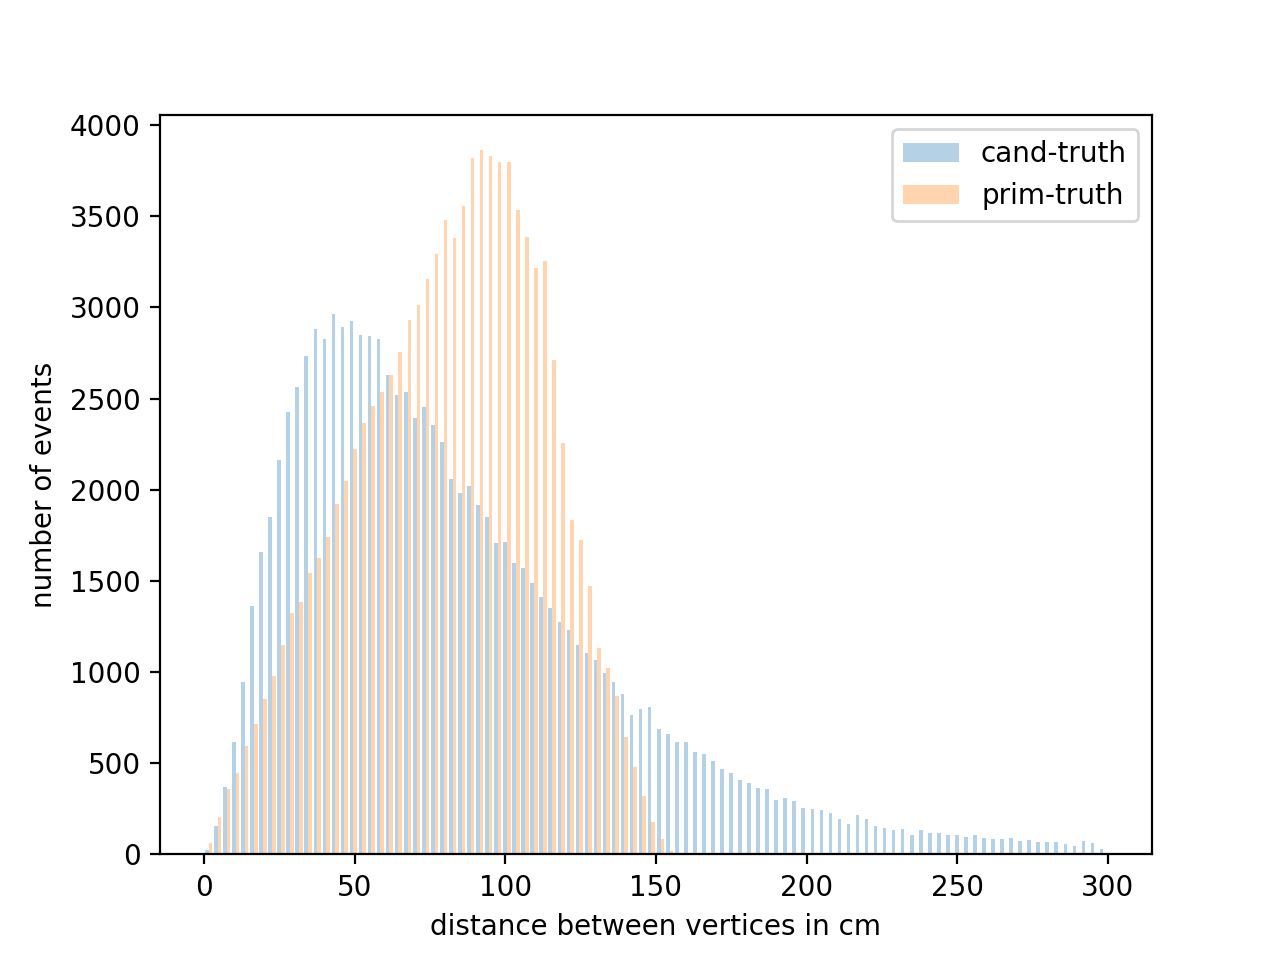

<IPython.core.display.Javascript object>


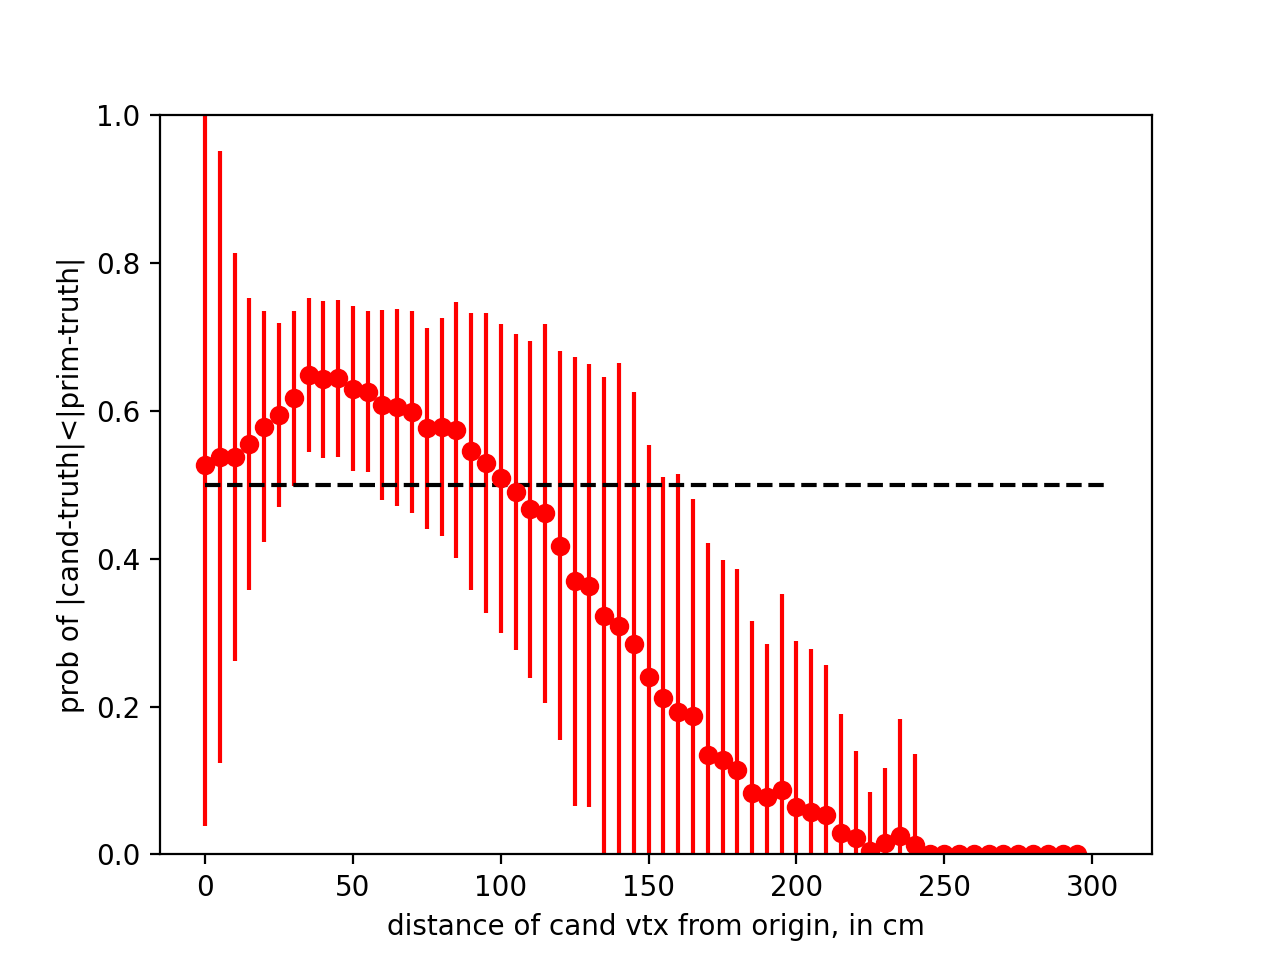

In [7]:
#cands2
%matplotlib notebook
plt.hist([[D_vtx(cands2[i],vtex[i][0]) for i in cands2.keys()],[D_vtx(vtex[i][1],vtex[i][0]) for i in cands2.keys()]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()

prob_plot(cands2.keys(),2)

In [19]:
## numbers, for the table. want to know how many events have |c-t|<|p-t|, and total

#cands0
def numbers(sample,spec):
    if spec == 0: 
        return [len([i for i in sample if D_vtx(cands0[i],vtex[i][0]) < D_vtx(vtex[i][0],vtex[i][1])]),len(sample)]
    elif spec == 1: 
        return [len([i for i in sample if D_vtx(cands1[i],vtex[i][0]) < D_vtx(vtex[i][0],vtex[i][1])]),len(sample)]
    elif spec == 2: 
        return [len([i for i in sample if D_vtx(cands2[i],vtex[i][0]) < D_vtx(vtex[i][0],vtex[i][1])]),len(sample)]
    elif spec == 3: 
        return [len([i for i in sample if D_vtx(cands3[i],vtex[i][0]) < D_vtx(vtex[i][0],vtex[i][1])]),len(sample)]
    elif spec == 4: 
        return [len([i for i in sample if D_vtx(cands4[i],vtex[i][0]) < D_vtx(vtex[i][0],vtex[i][1])]),len(sample)]
    elif spec == 5: 
        return [len([i for i in sample if D_vtx(cands5[i],vtex[i][0]) < D_vtx(vtex[i][0],vtex[i][1])]),len(sample)]
    else: print("wrgg")

In [29]:
numbers(cands0.keys(),0)[0]/numbers(cands0.keys(),0)[1]

0.5297678612121152

In [35]:
numbers(cands0.keys(),0)

[53470, 100931]

In [30]:
numbers(cands1.keys(),1)[0]/numbers(cands1.keys(),1)[1]

0.5230065189309354

In [36]:
numbers(cands1.keys(),1)

[52229, 99863]

In [31]:
numbers(cands2.keys(),2)[0]/numbers(cands2.keys(),2)[1]

0.5359538660703778

In [37]:
numbers(cands2.keys(),2)

[54648, 101964]

In [32]:
numbers(cands3.keys(),3)[0]/numbers(cands3.keys(),3)[1]

0.5293866359355441

In [38]:
numbers(cands3.keys(),3)

[53287, 100658]

In [33]:
numbers(cands4.keys(),4)[0]/numbers(cands4.keys(),4)[1]

0.5226190715333159

In [39]:
numbers(cands4.keys(),4)

[52033, 99562]

In [34]:
numbers(cands5.keys(),5)[0]/numbers(cands5.keys(),5)[1]

0.535611751288001

In [40]:
numbers(cands5.keys(),5)

[54476, 101708]

In [ ]:
#####winner: cands2.

<IPython.core.display.Javascript object>


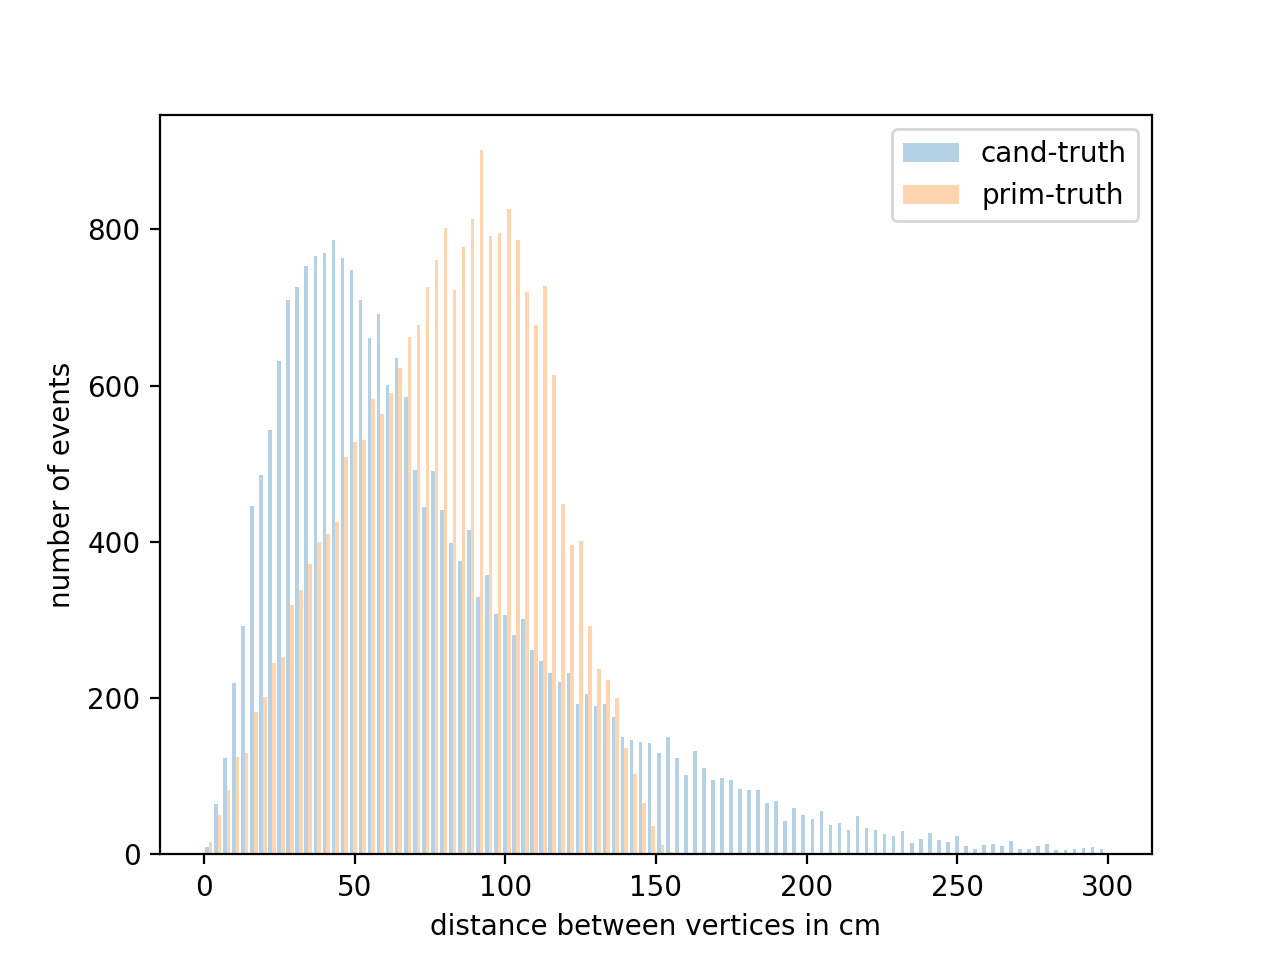

<IPython.core.display.Javascript object>


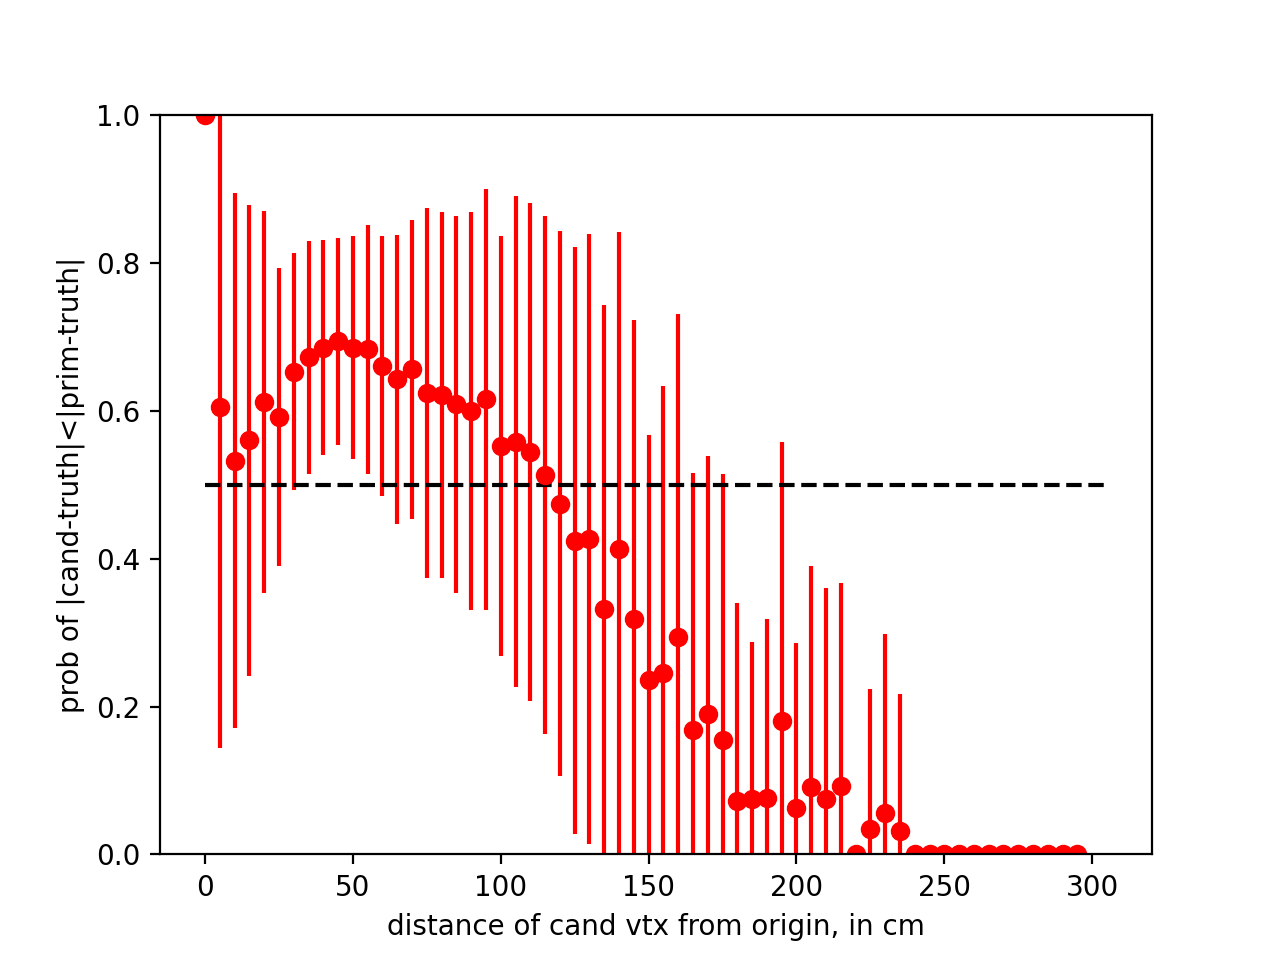

In [7]:
##seeample
%matplotlib notebook
plt.hist([[D_vtx(cands0[i],vtex[i][0]) for i in seeample],[D_vtx(vtex[i][1],vtex[i][0]) for i in seeample]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()

prob_plot(seeample,0)

In [55]:
##samples MAKING
#making zamples wrt cand vtx

zample1a = []
zample1b = []
zample1c = []
zample1d = []
zample1e = []
zample1f = []
zample2a = []
zample2b = []
zample2c = []
zample2d = []
zample2e = []
zample2f = []
zample4a = []
zample4b = []
zample4c = []
zample4d = []
zample4e = []
zample4f = []
zample4g = []
zample4h = []
zample4i = []
zample4j = []
zample4k = []

for i in cands2.keys():
    cand = cands2[i]
    
    if ((cand[0])**2 + (cand[1])**2 ) < 625.:
        zample1a.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 625. and ((cand[0])**2 + (cand[1])**2 ) < 2500.:
        zample1b.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 2500. and ((cand[0])**2 + (cand[1])**2 ) < 5625.:
        zample1c.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 5625. and ((cand[0])**2 + (cand[1])**2 ) < 10000.:
        zample1d.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 10000. and ((cand[0])**2 + (cand[1])**2 ) < 13225.:
        zample1e.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 13225.:
        zample1f.append(i)
        
    if abs(cand[2]) < 25.:
        zample2a.append(i)
    if abs(cand[2]) >= 25. and abs(cand[2]) < 50.:
        zample2b.append(i) 
    if abs(cand[2]) >= 50. and abs(cand[2]) < 75.:
        zample2c.append(i) 
    if abs(cand[2]) >= 75. and abs(cand[2]) < 100.:
        zample2d.append(i)
    if abs(cand[2]) >= 100. and abs(cand[2]) < 115.:
        zample2e.append(i)
    if abs(cand[2]) >= 115.:
        zample2f.append(i)
        
    dr = recoarray[i][0].DeltaR(recoarray[i][1]) % 2*(np.pi)
        
    if dr < np.pi/24.:
        zample4a.append(i)
    if dr >= np.pi/24. and dr < np.pi/12. :
        zample4b.append(i)
    if dr >= np.pi/12. and dr < np.pi/10. :
        zample4c.append(i)
    if dr >= np.pi/10. and dr < np.pi/8. :
        zample4d.append(i)
    if dr >= np.pi/8. and dr < np.pi/6. :
        zample4e.append(i)
    if dr >= np.pi/6. and dr < np.pi/5. :
        zample4f.append(i)
    if dr >= np.pi/5. and dr < np.pi/4. :
        zample4g.append(i)
    if dr >= np.pi/4. and dr < np.pi/3. :
        zample4h.append(i)
    if dr >= np.pi/3. and dr < np.pi/2. :
        zample4i.append(i)
    if dr >= np.pi/2. and dr < np.pi :
        zample4j.append(i)
    if dr >= np.pi :
        zample4k.append(i)
    
    else: continue
        
listz = [zample1a,zample1b,zample1c,zample1d,zample1e,zample1f,zample2a,zample2b,zample2c,zample2d,zample2e,zample2f,zample4a,zample4b,zample4c,zample4d,zample4e,zample4f,zample4g,zample4h,zample4i,zample4j,zample4k]

for i in range(len(listz)):
    print("zample %s : %s events" % (i,len(listz[i])))

zample 0 : 24595 events
zample 1 : 39524 events
zample 2 : 23685 events
zample 3 : 11191 events
zample 4 : 2968 events
zample 5 : 1 events
zample 6 : 36322 events
zample 7 : 27149 events
zample 8 : 15033 events
zample 9 : 8531 events
zample 10 : 3109 events
zample 11 : 11820 events
zample 12 : 3325 events
zample 13 : 2486 events
zample 14 : 443 events
zample 15 : 532 events
zample 16 : 753 events
zample 17 : 558 events
zample 18 : 1084 events
zample 19 : 2598 events
zample 20 : 9275 events
zample 21 : 44507 events
zample 22 : 36403 events


In [26]:
outerbp = intersection((zample1a),(zample2c+zample2d)) #zample1a

4623

In [57]:
outer = (zample1d + zample1e) + (zample2c + zample2e + zample2d)
outero = intersection((zample1d + zample1e),(zample2c + zample2e + zample2d))
outer = set(outer) - set(outero)
len(outer)

31312

<IPython.core.display.Javascript object>


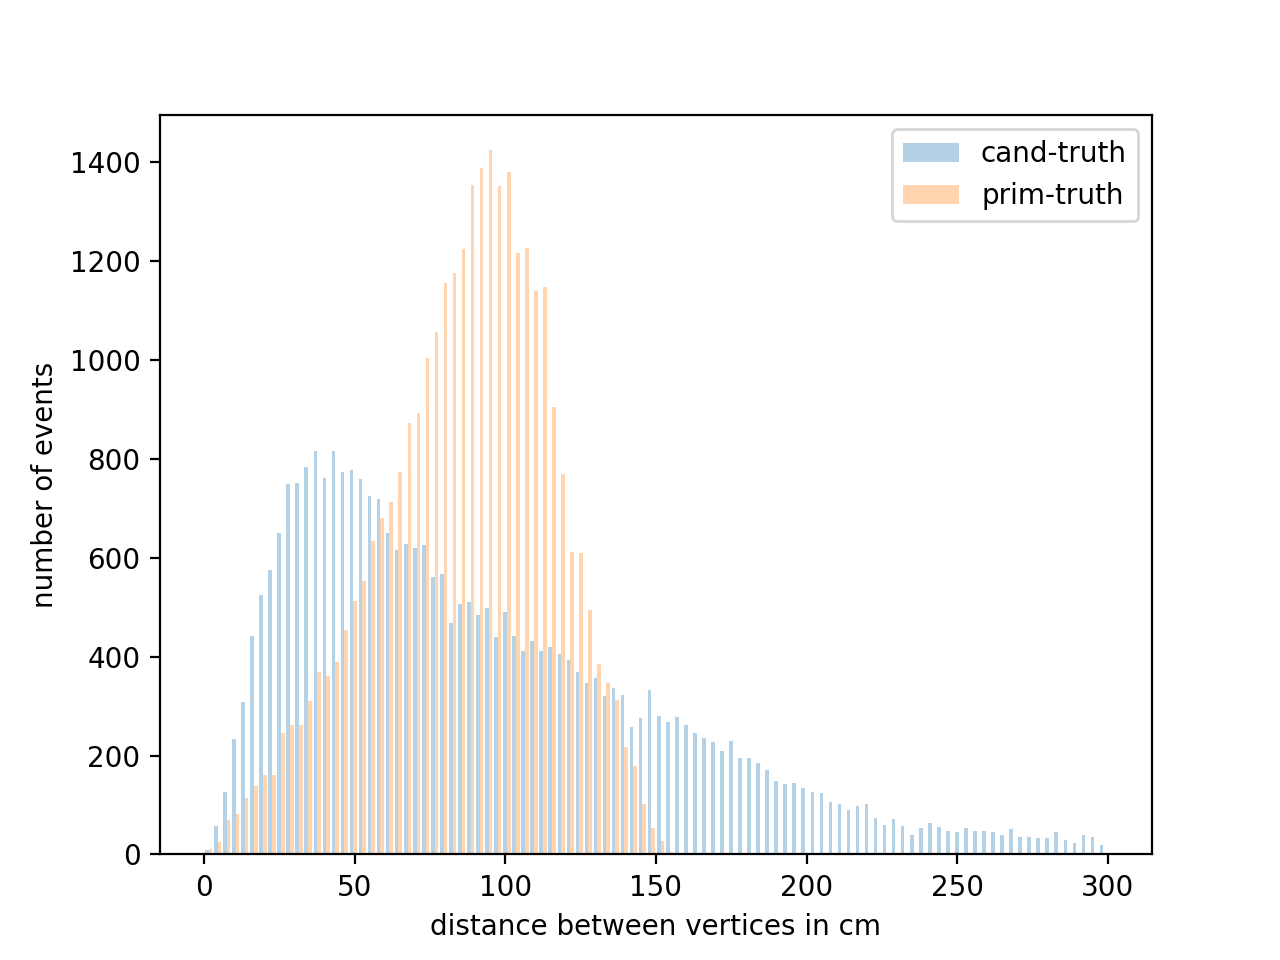

<IPython.core.display.Javascript object>


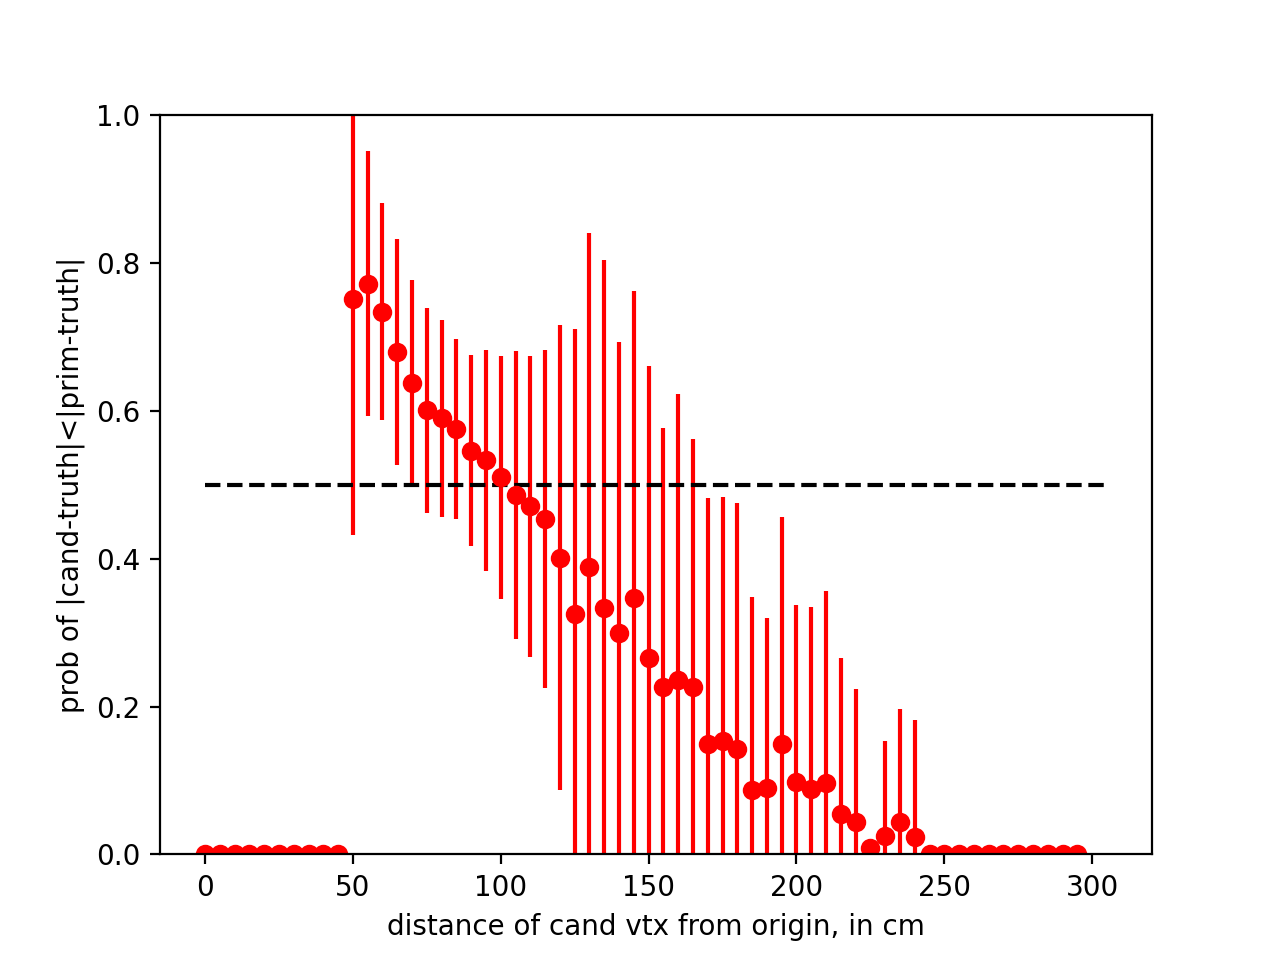

In [42]:
%matplotlib notebook
plt.hist([[D_vtx(cands2[i],vtex[i][0]) for i in outer],[D_vtx(vtex[i][1],vtex[i][0]) for i in outer]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()

prob_plot(outer,2)

<IPython.core.display.Javascript object>


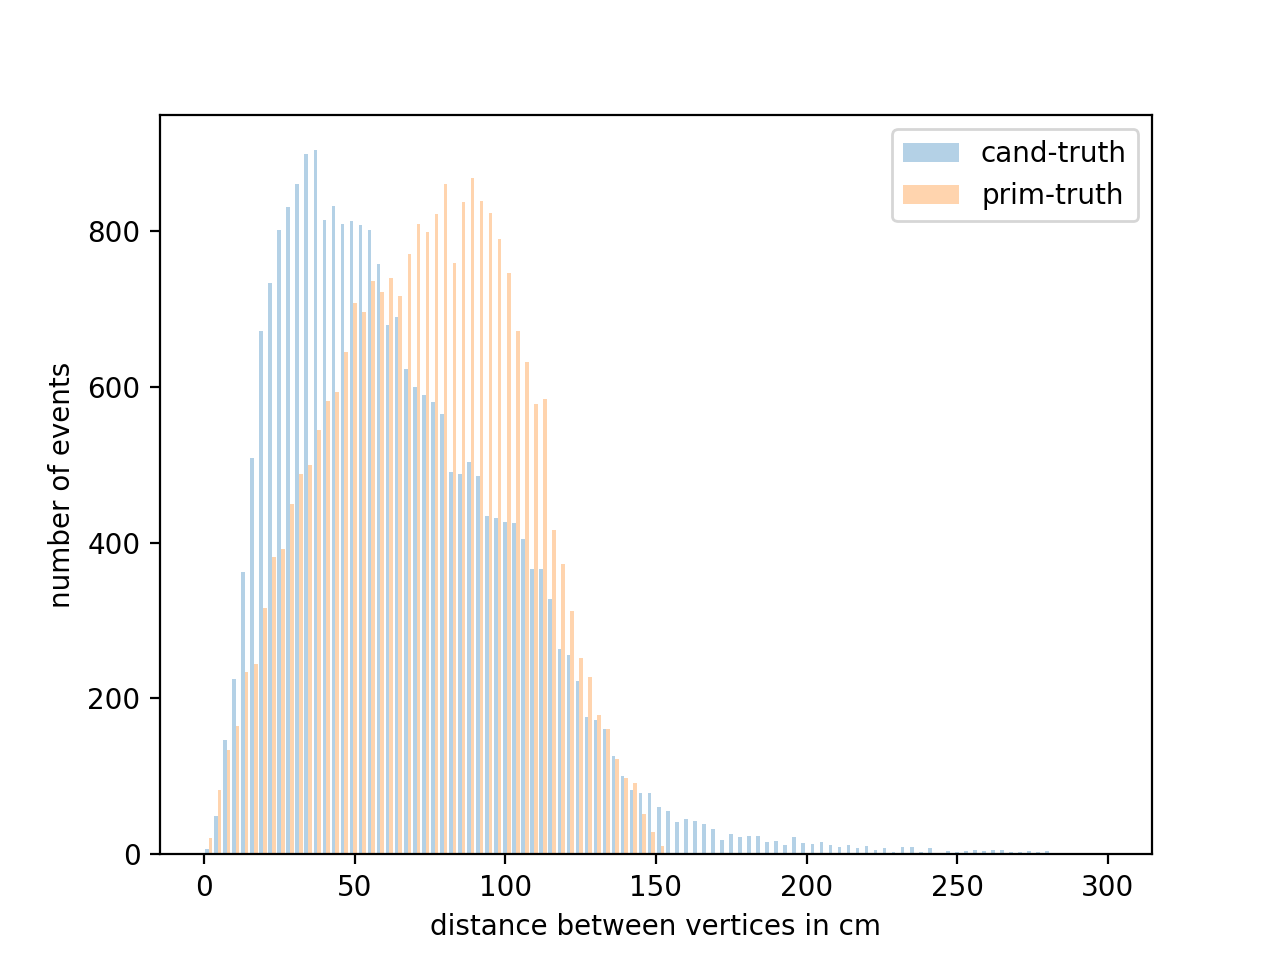

<IPython.core.display.Javascript object>


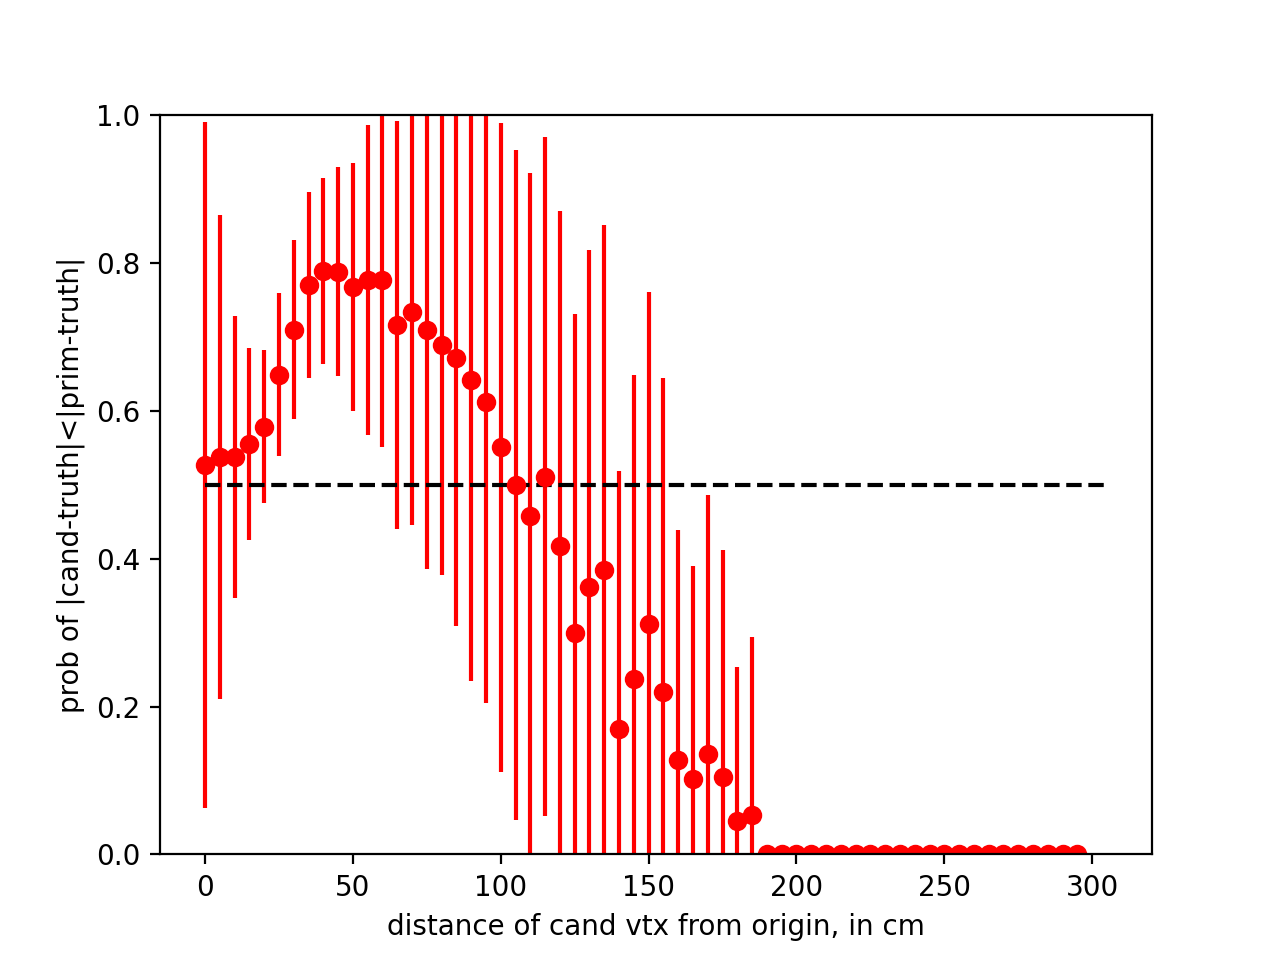

In [43]:
plt.hist([[D_vtx(cands2[i],vtex[i][0]) for i in zample1a],[D_vtx(vtex[i][1],vtex[i][0]) for i in zample1a]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()

prob_plot(zample1a,2)

In [47]:
len(cands2.keys())

101964

<IPython.core.display.Javascript object>


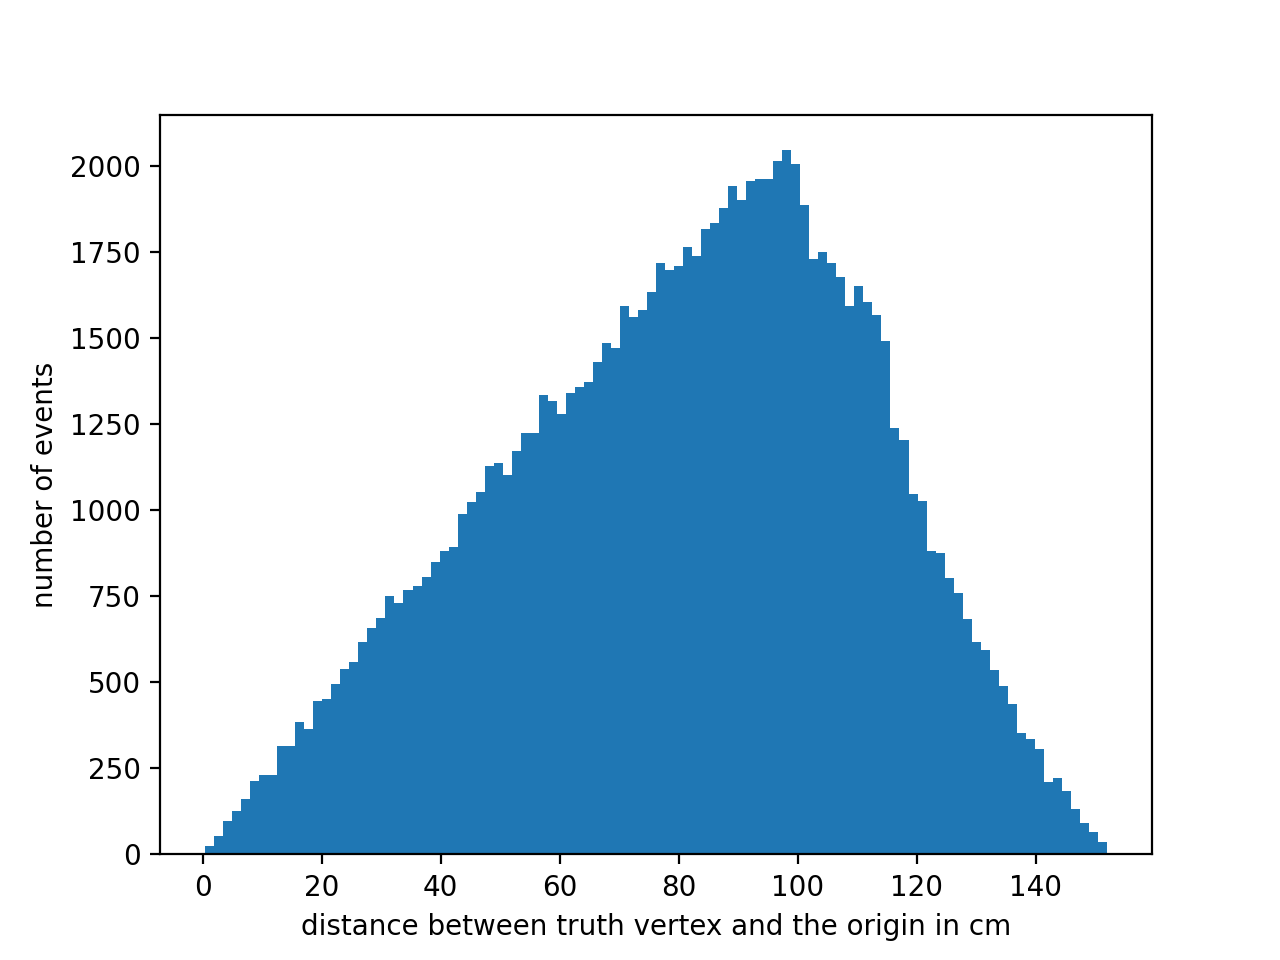

In [45]:
plt.hist([D_vtx([0,0,0],vtex[i][0]) for i in cands2.keys()],bins=100)
plt.xlabel("distance between truth vertex and the origin in cm");
plt.ylabel("number of events");
plt.show()

<IPython.core.display.Javascript object>


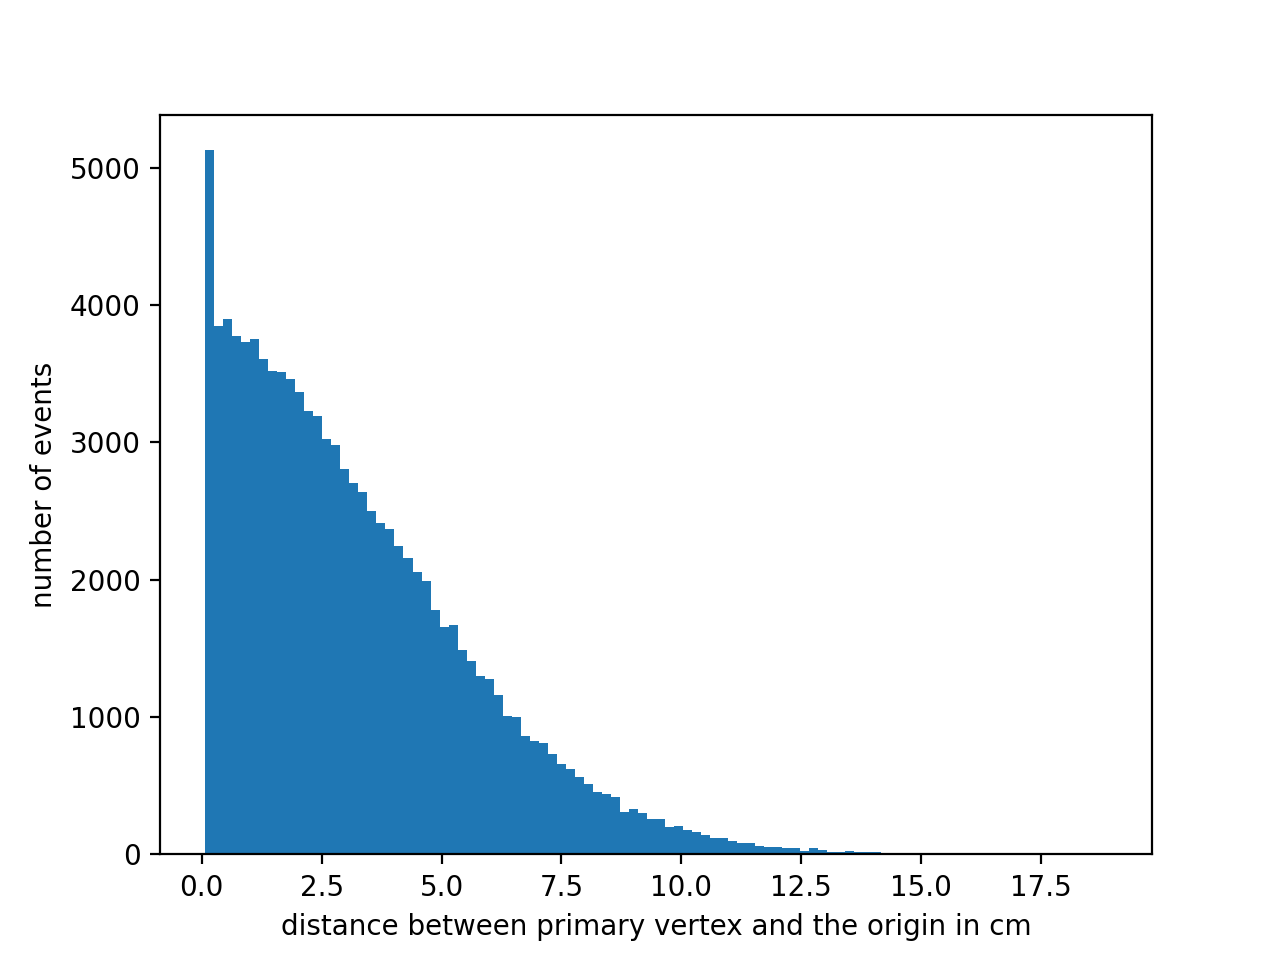

In [48]:
plt.hist([D_vtx([0,0,0],vtex[i][1]) for i in cands2.keys()],bins=100)
plt.xlabel("distance between primary vertex and the origin in cm");
plt.ylabel("number of events");
plt.show()

sample 0:


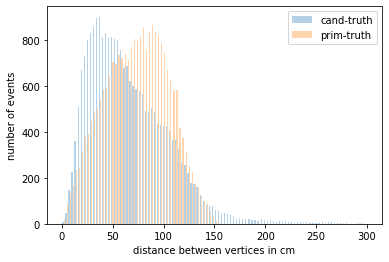

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


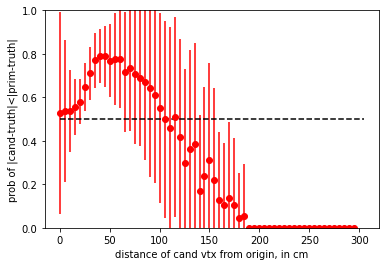

sample 1:


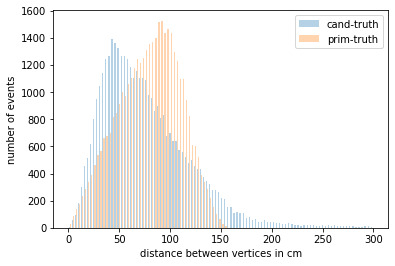

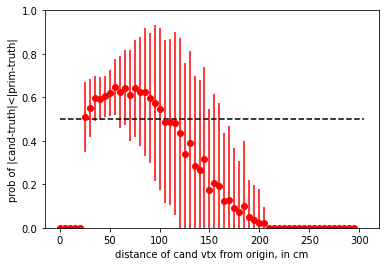

sample 2:


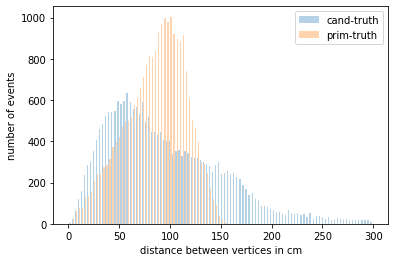

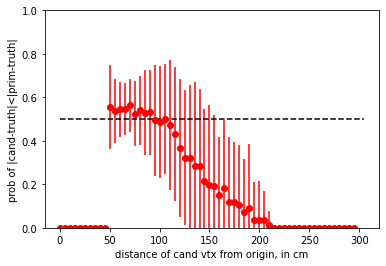

sample 3:


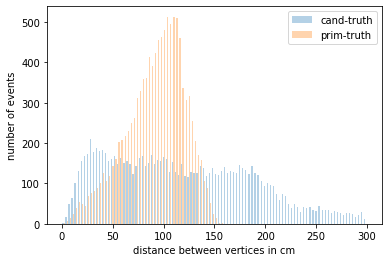

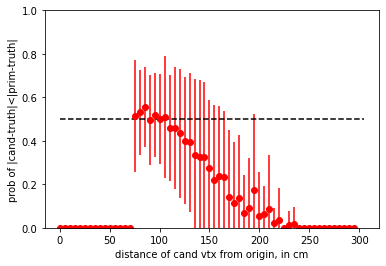

sample 4:


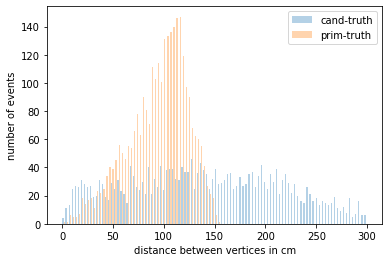

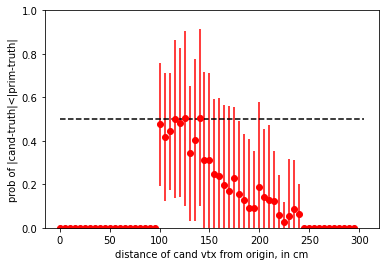

sample 5:


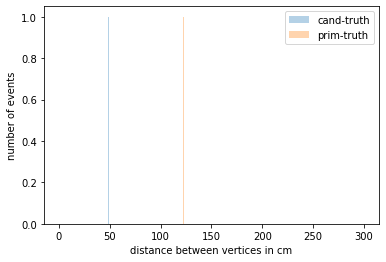

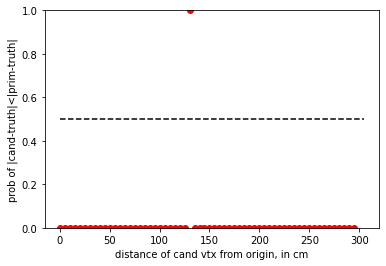

sample 6:


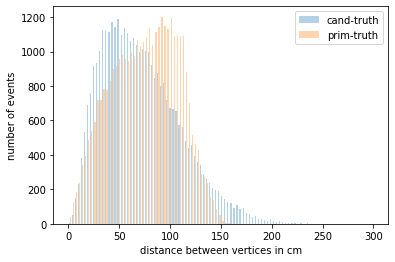

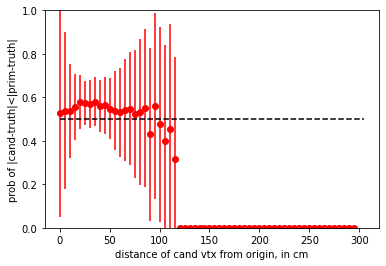

sample 7:


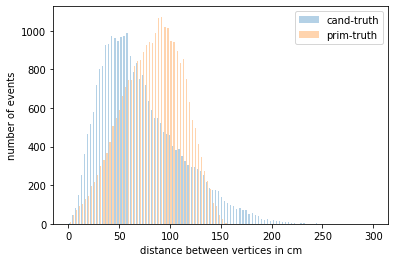

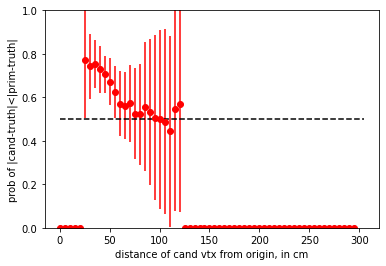

sample 8:


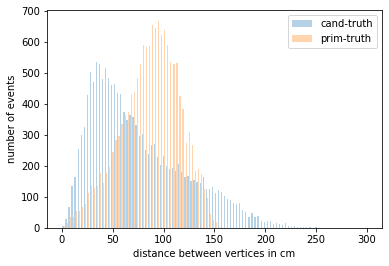

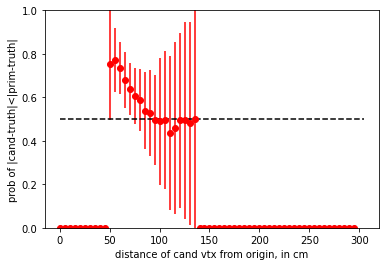

sample 9:


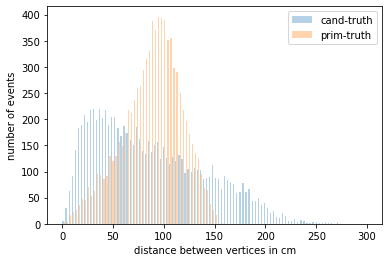

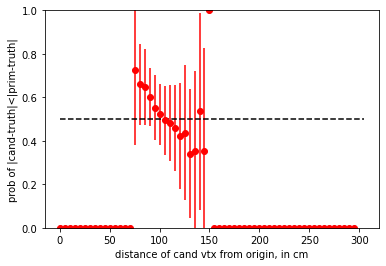

sample 10:


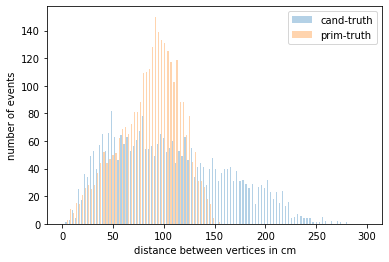

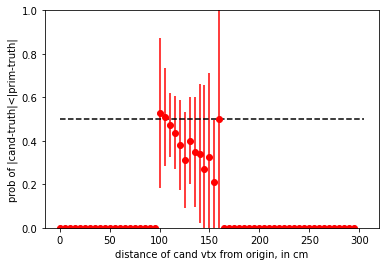

sample 11:


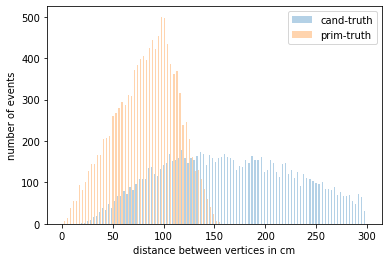

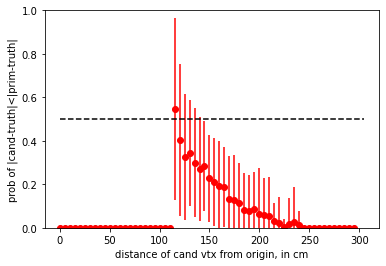

sample 12:


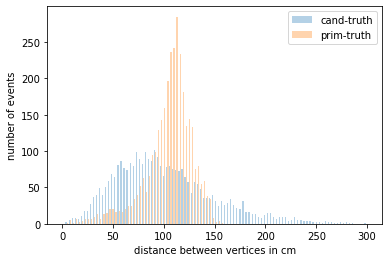

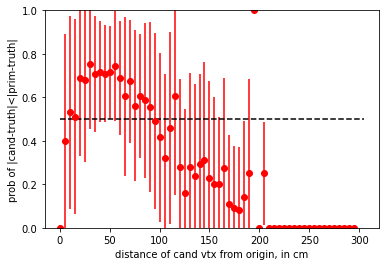

sample 13:


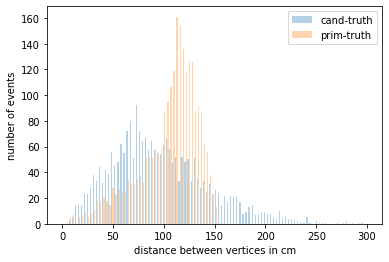

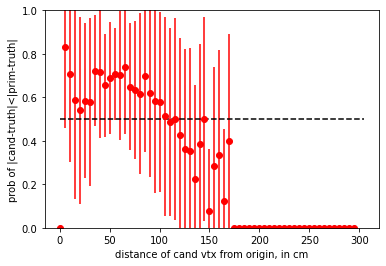

sample 14:


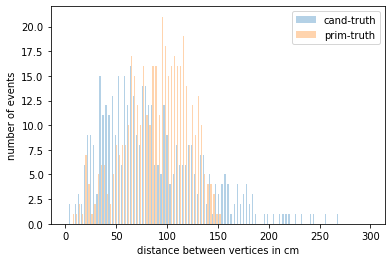

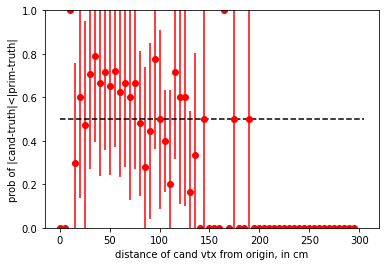

sample 15:


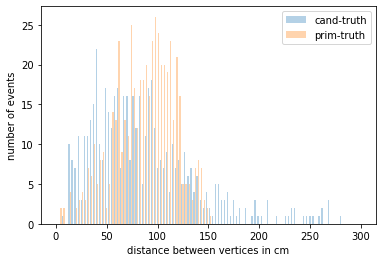

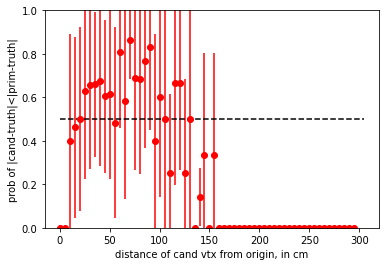

sample 16:


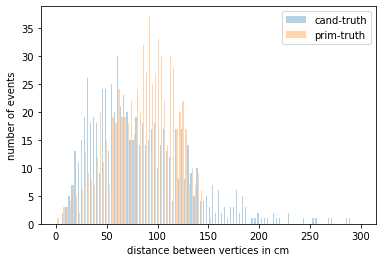

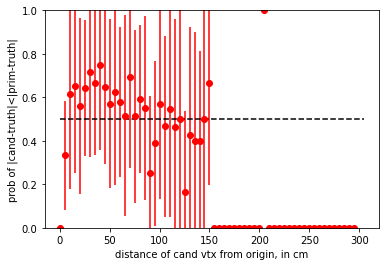

sample 17:


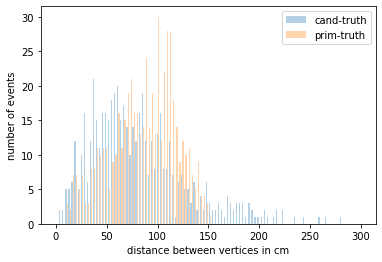

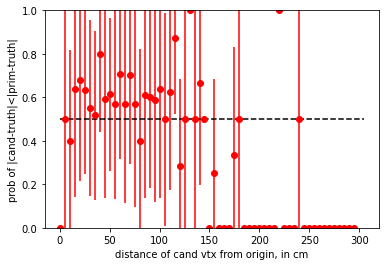

sample 18:


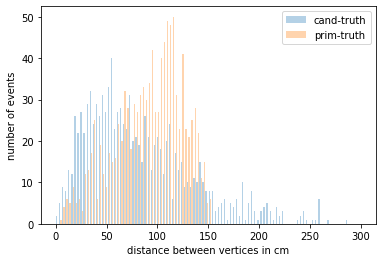

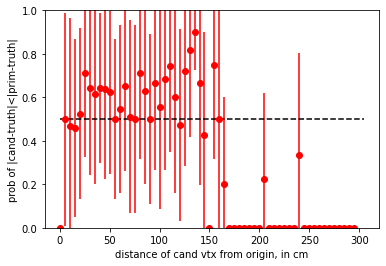

sample 19:


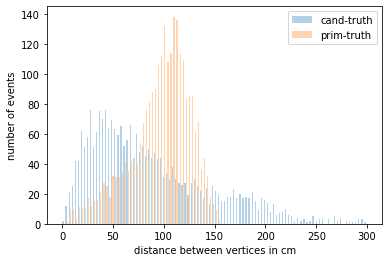

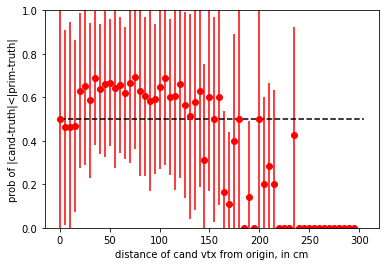

sample 20:


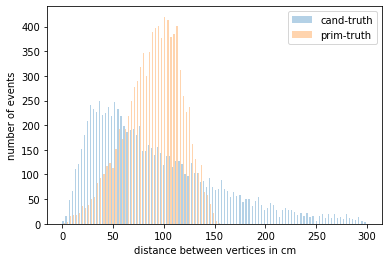

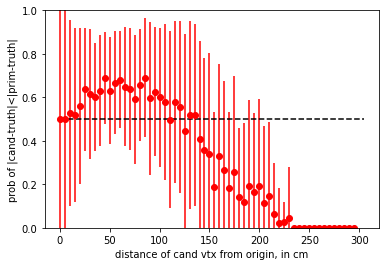

sample 21:


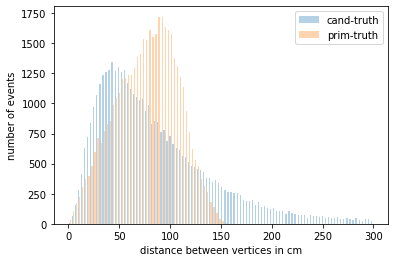

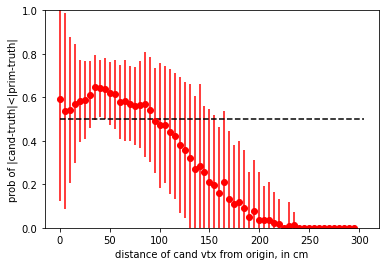

sample 22:


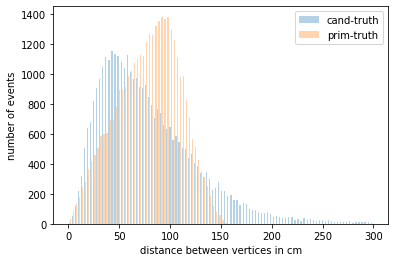

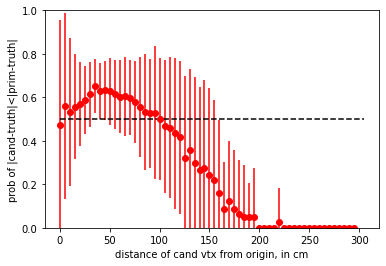

In [8]:
for i in range(len(listz)):
    sample = listz[i]
    print("sample %s:" % i)
    plt.hist([[D_vtx(cands2[i],vtex[i][0]) for i in sample],[D_vtx(vtex[i][1],vtex[i][0]) for i in sample]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
    plt.xlabel("distance between vertices in cm");
    plt.ylabel("number of events");
    plt.legend();
    plt.show()

    prob_plot(sample,2)

In [16]:
unboosted = zample4k + zample4j

<IPython.core.display.Javascript object>


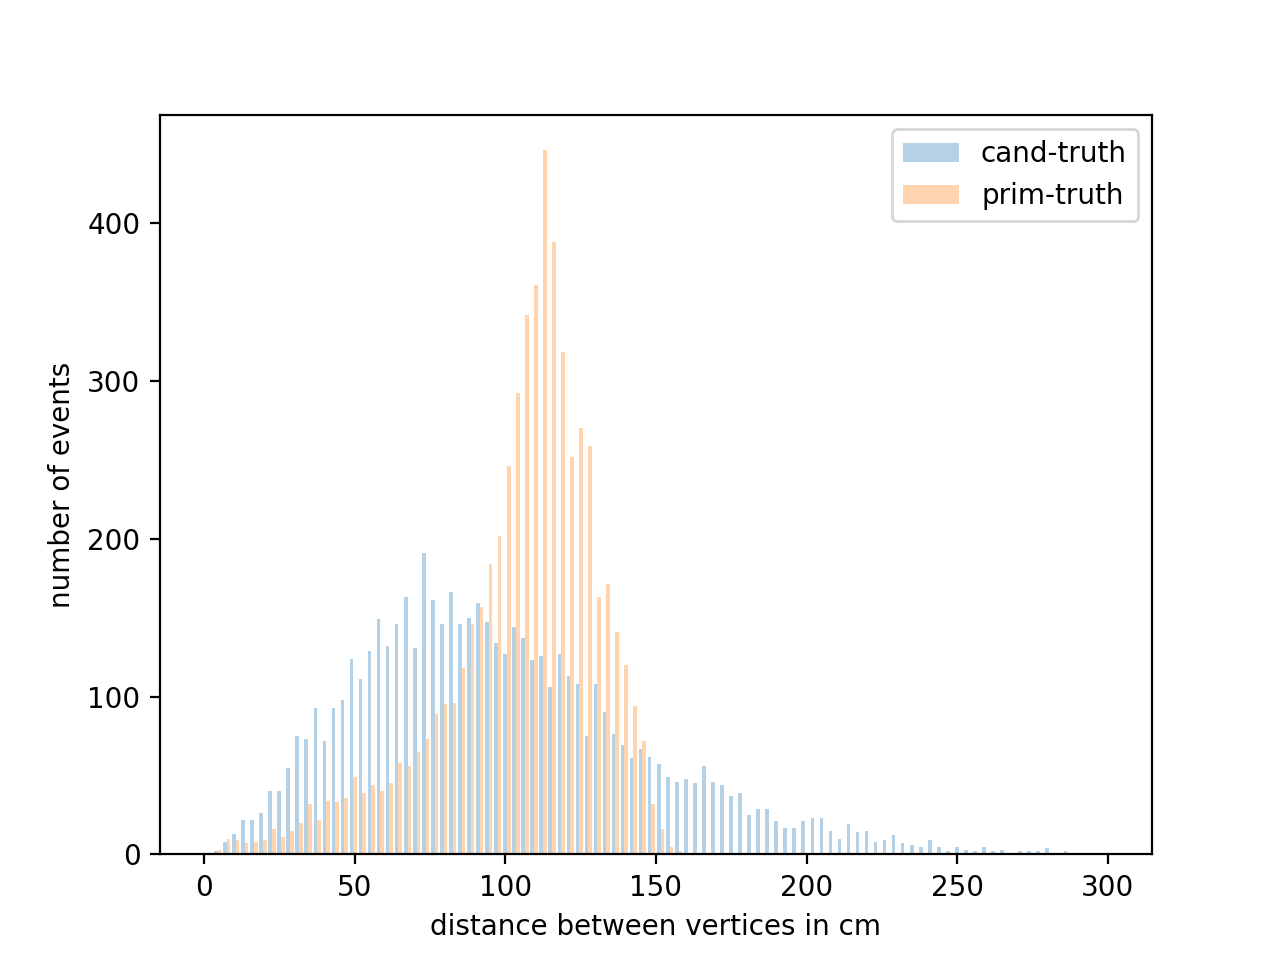

In [11]:
##boosted
%matplotlib notebook
plt.hist([[D_vtx(cands2[i],vtex[i][0]) for i in boosted],[D_vtx(vtex[i][1],vtex[i][0]) for i in boosted]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()

<IPython.core.display.Javascript object>


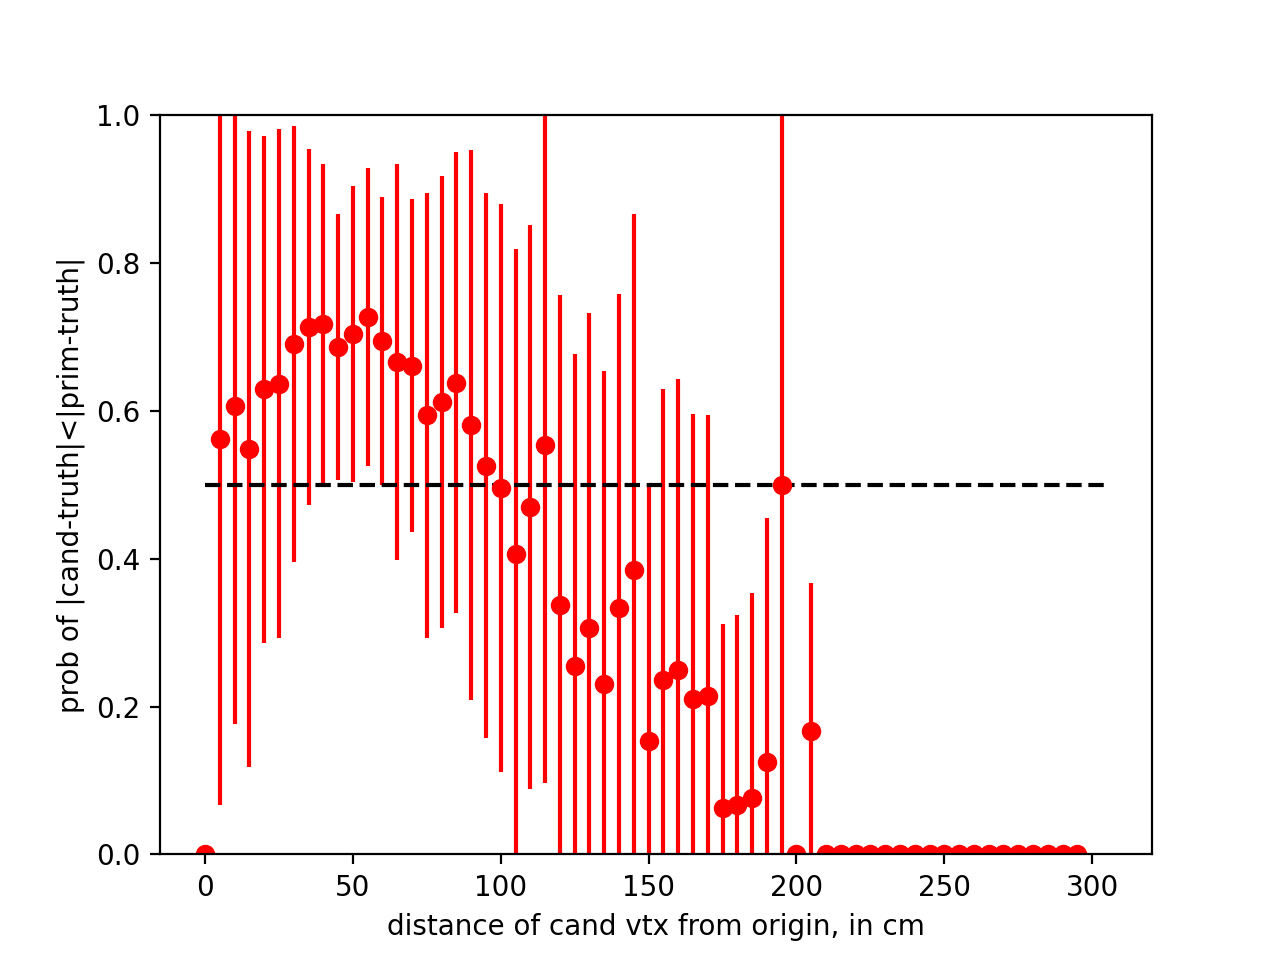

In [13]:
prob_plot(boosted,2)

<IPython.core.display.Javascript object>


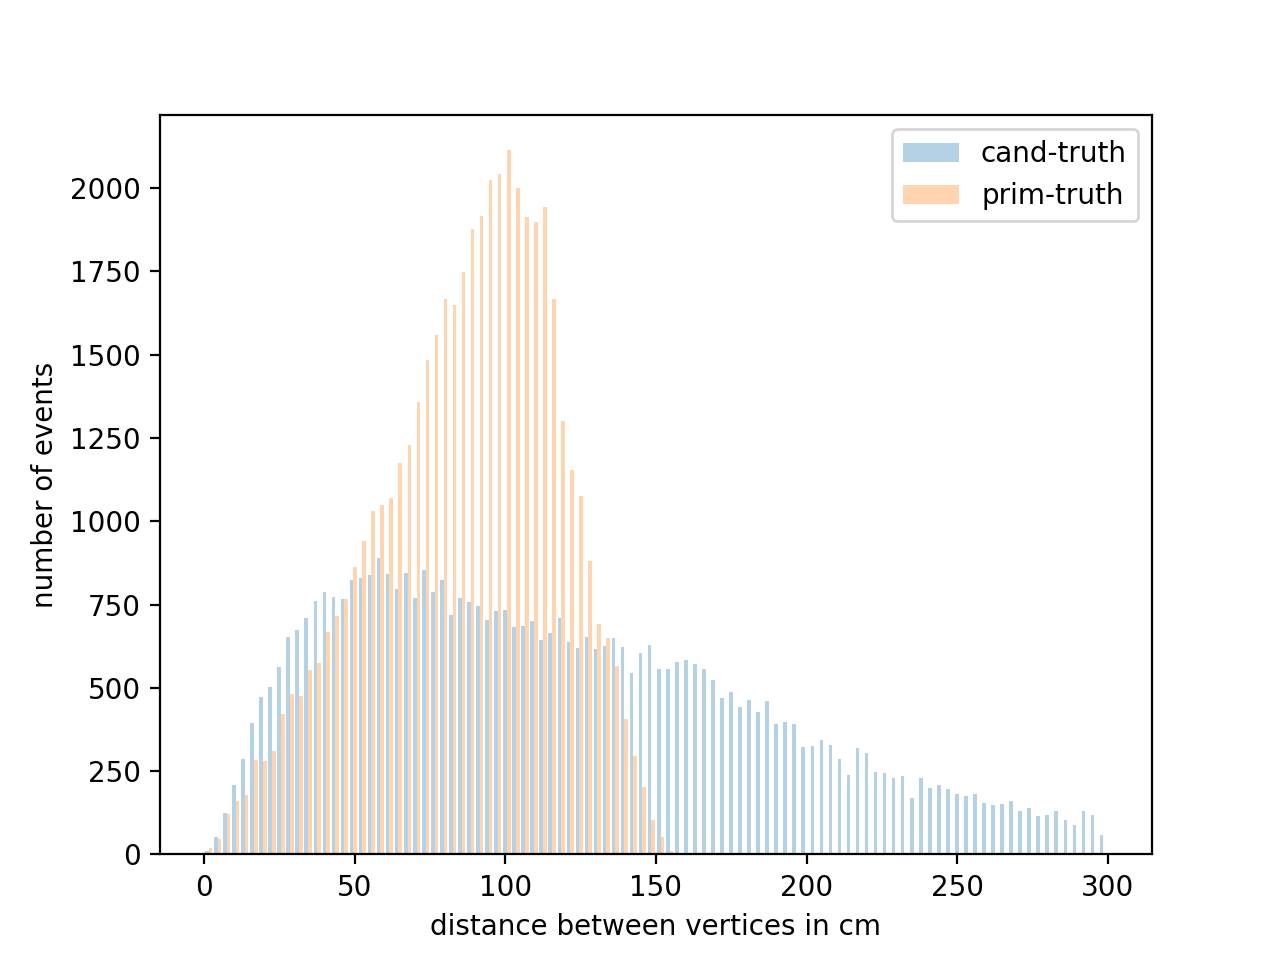

In [14]:
##outer
%matplotlib notebook
plt.hist([[D_vtx(cands2[i],vtex[i][0]) for i in outer],[D_vtx(vtex[i][1],vtex[i][0]) for i in outer]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()

<IPython.core.display.Javascript object>


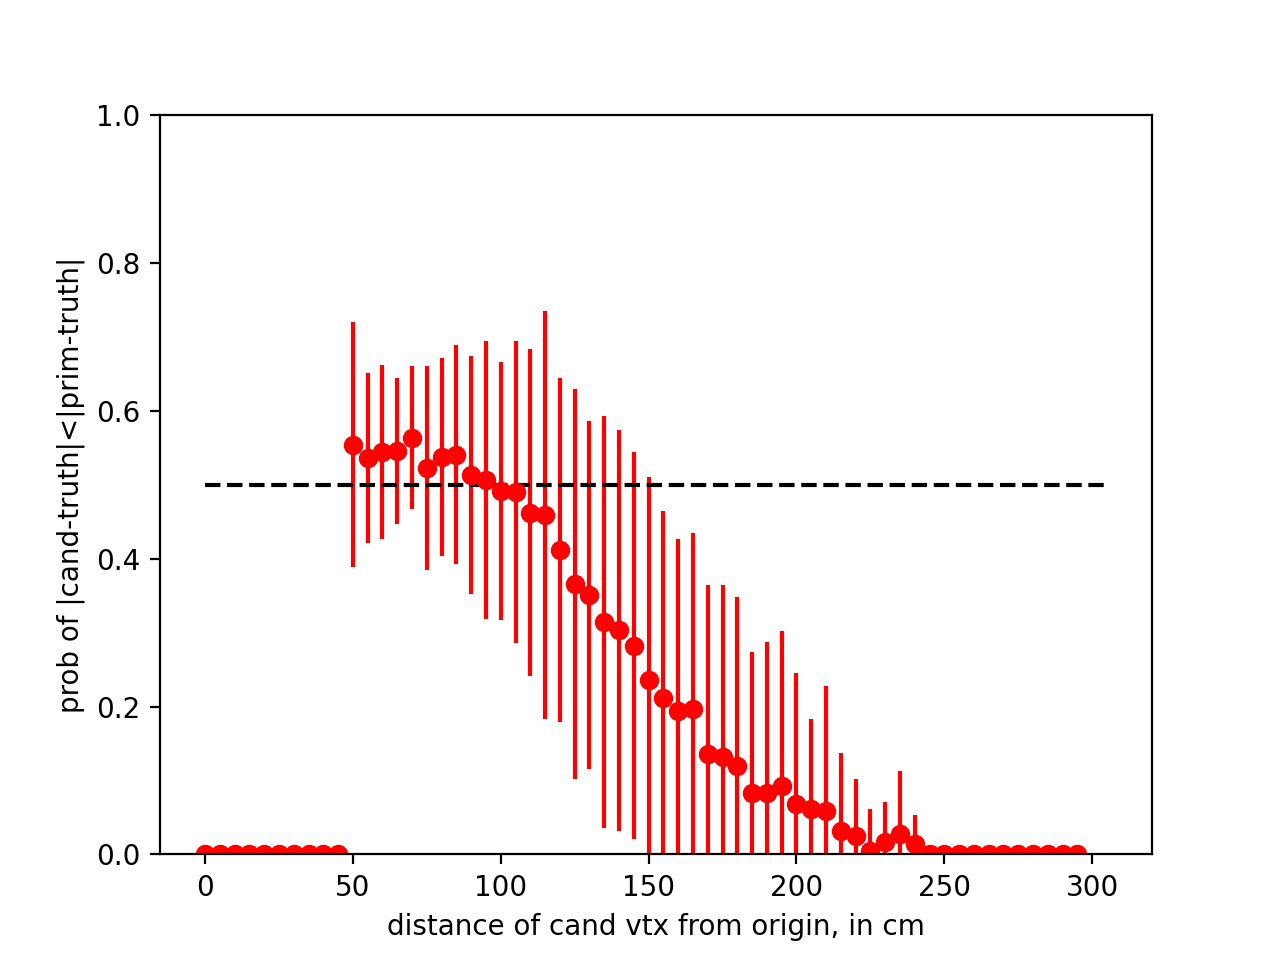

In [15]:
prob_plot(outer,2)

<IPython.core.display.Javascript object>


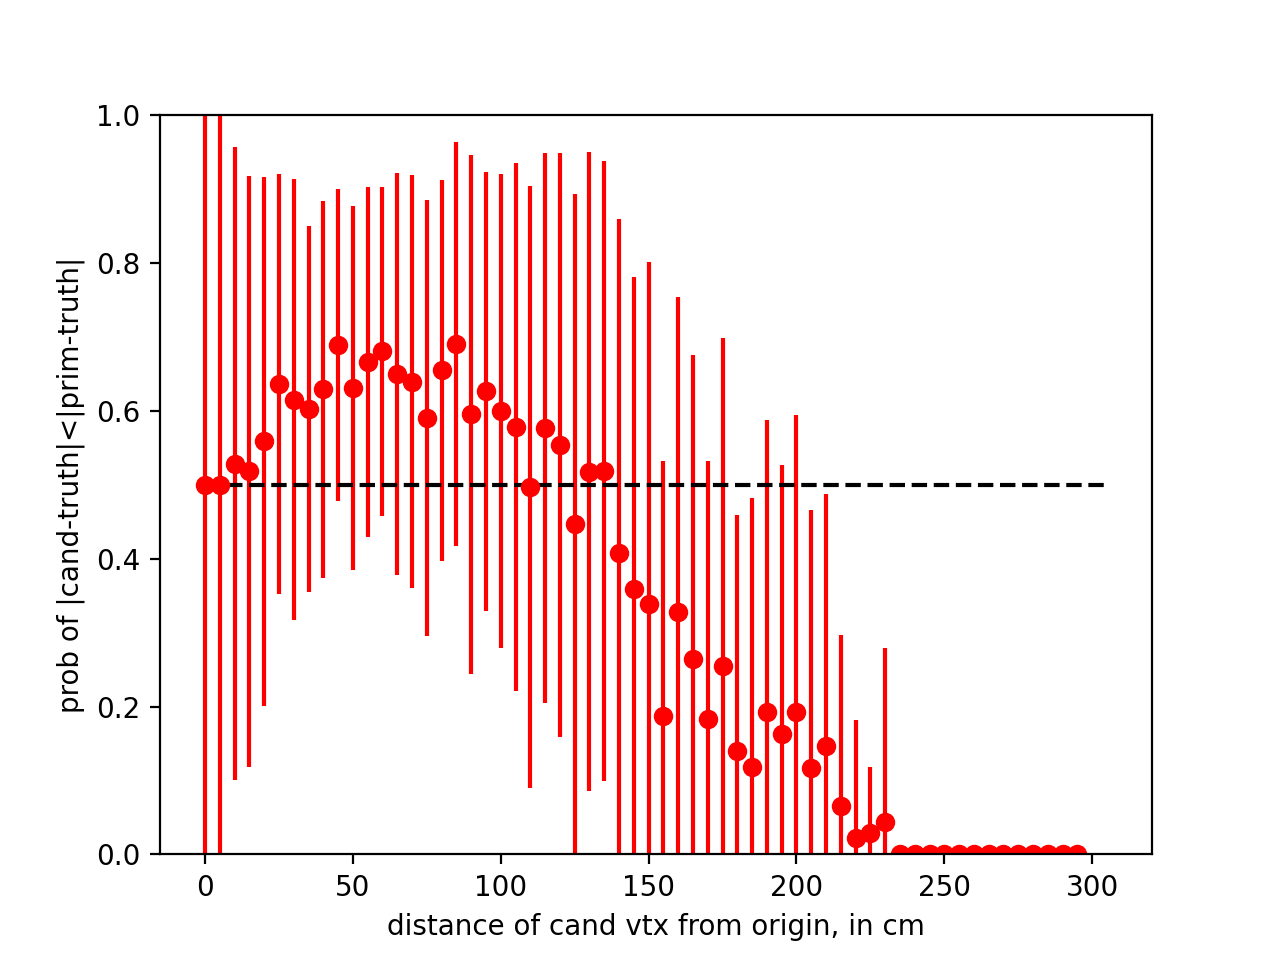

In [21]:
prob_plot(zample4i,2)

In [ ]:
#master ,[list(range(0,300,5)),waluelist],label=["prob","weight"]
%matplotlib notebook
plt.hist([[D_vtx(cands[i],vtex[i][0]) for i in seeample],[D_vtx(vtex[i][1],vtex[i][0]) for i in seeample]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()

In [ ]:
a = prob_plot(cands.keys())

In [ ]:
%matplotlib notebook
plt.hist([D_vtx(cands[i],[0,0,0]) for i in cands.keys()],bins=100,range=[0,500])
plt.yscale("log")

In [ ]:
plt.hist([D_vtx(cands[i],[0,0,0]) for i in cands.keys()],bins=100,range=[0,500])

In [ ]:
def ang_sep(ev):
    cell1 = picktop2(ev)["1"][2]
    cell2 = picktop2(ev)["2"][2]
    e1 = cell1[1]
    e2 = cell2[1]
    p1 = cell1[2]
    p2 = cell2[2]
    dr = (e1 - e2)**2 + (p1 - p2)**2
    return dr % (2*np.pi)

In [ ]:
#plotting zamples

for i in range(len(listz)):
    Sample = listz[i]
    print("--------sample %s"% i)
    print("%i events" % len(Sample))
    plt.hist([[D_vtx(cands[i],vtex[i][0]) for i in Sample],[D_vtx(vtex[i][1],vtex[i][0]) for i in Sample]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
    plt.xlabel("distance between vertices in cm");
    plt.ylabel("number of events");
    plt.legend();
    plt.show()
    print("")
    prob_plot(Sample)
    print(" ")

In [ ]:
boosted = zample4a+zample4b
len(boosted)

In [ ]:
beampipe = intersection(zample1a,zample2e)

In [ ]:
outer = intersection(zample1f,(zample2a+zample2b))

In [ ]:
inner = zample1a + zample2a
outer = zample1e + zample2e + zample2d +zample2c
len(outer)

In [ ]:
%matplotlib notebook
plt.hist([[D_vtx(cands[i],vtex[i][0]) for i in outer],[D_vtx(vtex[i][1],vtex[i][0]) for i in outer]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()
#print(" ")
#prob_plot(boosted)

In [ ]:
prob_plot(outer)

In [ ]:
plt.hist([[D_vtx(cands[i],vtex[i][0]) for i in beampipe],[D_vtx(vtex[i][1],vtex[i][0]) for i in beampipe]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()
print(" ")
prob_plot(beampipe)

In [ ]:
plt.hist([[D_vtx(cands[i],vtex[i][0]) for i in outer],[D_vtx(vtex[i][1],vtex[i][0]) for i in outer]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()
print(" ")
prob_plot(outer)

In [ ]:
Outer = zample1f + zample2e

In [ ]:
plt.hist([[D_vtx(cands[i],vtex[i][0]) for i in Outer],[D_vtx(vtex[i][1],vtex[i][0]) for i in Outer]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()
print(" ")
prob_plot(Outer)

In [ ]:
Inner = cands.keys() - Outer

In [ ]:
plt.hist([[D_vtx(cands[i],vtex[i][0]) for i in Inner],[D_vtx(vtex[i][1],vtex[i][0]) for i in Inner]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()
print(" ")
prob_plot(Inner)

In [ ]:
len(Inner)